In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
from astropy.table import Table, Column, join, unique
import pandas as pd
import numpy as np
import os
import string as s
import emcee
import corner

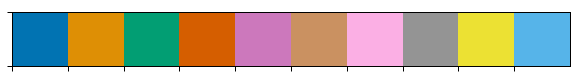

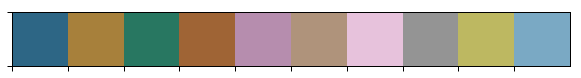

In [2]:
#deine the path to save the plots
plot_path = '/Users/Briana/Documents/Grad_School/HPS/Paper_Plots'
sns.set_context('paper')
#sns.set_style("ticks", {"xtick.major.size": 50, "ytick.major.size": 50})
sns.set_palette("colorblind")

cmap=sns.color_palette('colorblind')
cmap_l = sns.color_palette('colorblind', desat=.5)
sns.palplot(cmap)
sns.palplot(cmap_l)

# Define HPS MZR data

In [3]:
#read in fluxes for OII selected HPS_objects
hps_fluxes_o2 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/OII_norm_fluxes.csv')
id_conv = hps_fluxes_o2.loc[:,['HPS_name', 'ID']]
#print hps_fluxes

#read in fluxes for OIII selected HPS_objects
hps_fluxes_o3 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/OIII_norm_fluxes.csv')
id_conv_o3 = hps_fluxes_o3.loc[:,['HPS_name', 'ID']]

hps_fluxes = pd.concat([hps_fluxes_o2, hps_fluxes_o3], sort=True)

print hps_fluxes_o3

   Unnamed: 0  [OII]3727  [NeIII]3870  [Hb]4861  [OIII]5007  [Ha]6562  \
0           9   1.012775        0.449  0.392073        2.44  1.428198   
1          14   0.902217        0.009  0.143054        0.66  1.207833   

   [NII]6583  [OII]3727_e  [NeIII]3870_e  [Hb]4861_e  [OIII]5007_e  \
0   0.073939     0.686858       0.391100    0.187804      0.274354   
1   0.014631     0.482808       0.182069    0.093403      0.206453   

   [Ha]6562_e  [NII]6583_e Source          HPS_name     ID  [OIII]_HPS  \
0    0.151770     0.058373   LRS2  HPS100021+021351  234.0        2.44   
1    0.126798     0.043892   LRS2  HPS123652+621125  430.0        0.66   

   [OIII]_e_HPS  [Ne]3870  Hb_absorption  
0      0.173050  0.436826           0.12  
1      0.111864  0.014631           0.30  


In [8]:
#read in my mass and metallicities for the OII selected HPS objects 
df = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OII.csv')
df = pd.merge(df, id_conv, on='HPS_name', how='left')

df_wNe = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OII_w_NeIII.csv')
df_wNe = df_wNe.loc[:,['HPS_name', 'metallicity', 'met_err', 'E(B-V)', 'E(B-V)_err']]
df_wNe.rename(columns={'metallicity':'metallicity_wNe', 'met_err':'met_err_wNe', 'E(B-V)':'E(B-V)_wNe', 'E(B-V)_err':'E(B-V)_err_wNe'}, inplace=True)
df = pd.merge(df, df_wNe, on='HPS_name', how='left')

df_curti = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OII_curti.csv')
df_curti.rename(columns={'metallicity':'metallicity_c', 'E(B-V)':'E(B-V)_c', 'OIII_intrinsic':'OIII_intrinsic_c', 'met_err':'met_err_c', 'E(B-V)_err':'E(B-V)_err_c', 'OIII_int_err':'OIII_int_err_c'}, inplace=True)
df = pd.merge(df, df_curti, on='HPS_name', how='left')

# df_t_half = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/Metallicty_emcee/met_mcmc_results_OII/hps_metallicty_measures_norm_OII_test_half.csv')
# df_t_half = df_t_half.loc[:,['HPS_name', 'metallicity']]
# df_t_half.rename(columns={'metallicity':'metallicity_t_half'}, inplace=True)
# df = pd.merge(df, df_t_half, on='HPS_name', how='left')

# df_t_hbc = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/Metallicty_emcee/met_mcmc_results_OII/hps_metallicty_measures_norm_OII_test_woHbcorr.csv')
# df_t_hbc = df_t_hbc.loc[:,['HPS_name', 'metallicity']]
# df_t_hbc.rename(columns={'metallicity':'metallicity_t_hbc'}, inplace=True)
# df = pd.merge(df, df_t_hbc, on='HPS_name', how='left')

df['selection'] = 'OII'

#load in table from Joanna's paper
bridge = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_bridge_table.ascii', delim_whitespace=True)
bridge_mass = bridge.loc[:,['HPS_name','logM']]

# hps_mass = Table.read('/Volumes/Briana_mac3/HPS/hps_fits.dat', format='ascii.fixed_width_two_line')
# hps_mass = hps_mass.to_pandas()
hps_mass = pd.read_table('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_fits.dat', delim_whitespace=True)

#merge the masses with the metallicity table 
met_merge_bridge = pd.merge(df, bridge_mass, on='HPS_name', how='left')
met_merge_greg   = pd.merge(df, hps_mass, on='ID', how='left')

met_merge_bridge.dropna(subset=['logM'], inplace=True)
met_merge_greg.dropna(subset=['LogMass_50'], inplace=True)

met_merge_greg['Z_50'] = 10**(met_merge_greg['LogZ_50'])
print(met_merge_greg[['metallicity', 'Z_50']])

#define mass and metallicity from data and metallicity errors
#mass = met_merge['logM']
mass_bridge = met_merge_bridge['logM']
mass_greg   = met_merge_greg['LogMass_50']
mass_e_up   = met_merge_greg['LogMass_50'] - met_merge_greg['LogMass_16']
mass_e_lo   = met_merge_greg['LogMass_84'] - met_merge_greg['LogMass_50']

met_bridge = met_merge_bridge['metallicity']
met_greg = met_merge_greg['metallicity']
met_greg_c = met_merge_greg['metallicity_c']

m_u_lis_b = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in met_merge_bridge['met_err'].values]
m_l_lis_b = [float(s.split(s.split(l,']')[0], ',')[1]) for l in met_merge_bridge['met_err'].values]
met_err_b = np.divide(np.add(m_u_lis_b, m_l_lis_b),2)

m_u_lis_g = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in met_merge_greg['met_err'].values]
m_l_lis_g = [float(s.split(s.split(l,']')[0], ',')[1]) for l in met_merge_greg['met_err'].values]
met_err_g = np.divide(np.add(m_u_lis_g, m_l_lis_g),2)

m_u_lis_g_c = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in met_merge_greg['met_err_c'].values]
m_l_lis_g_c = [float(s.split(s.split(l,']')[0], ',')[1]) for l in met_merge_greg['met_err_c'].values]
met_err_g_c = np.divide(np.add(m_u_lis_g_c, m_l_lis_g_c),2)

#print df.loc[:,['HPS_name', 'metallicity', 'metallicity_t_half', 'metallicity_t_hbc']]

    metallicity      Z_50
0      8.891323  1.035142
1      8.773487  0.635331
3      8.565194  0.393550
4      8.775848  0.662217
5      8.792618  1.099006
6      8.727978  0.570164
7      8.497223  0.554626
8      8.762508  0.776247
10     8.820106  0.576766
11     8.760042  0.729458
12     8.830266  0.574116
13     8.671799  0.671429
14     8.897069  0.703072
15     8.659576  0.603949
16     8.983205  0.984011
17     8.747863  0.801678
18     8.694257  0.450817
19     8.467661  0.423643
20     8.743019  0.959401
21     8.708249  0.914113
22     8.649015  1.367729
23     8.826073  0.399025
24     8.691292  0.449780
25     8.835848  0.651628
26     8.552775  0.087700
27     8.805535  0.845279
28     8.781437  0.699842


/Users/Briana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


In [50]:
#read in my mass and metallicities for the OIII selected HPS objects 
df_o3 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OIII.csv')
df_o3 = pd.merge(df_o3, id_conv_o3, on='HPS_name', how='left')

df_wNe_o3 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OIII_w_NeIII.csv')
df_wNe_o3 = df_wNe_o3.loc[:,['HPS_name','metallicity', 'met_err', 'E(B-V)', 'E(B-V)_err']]
df_wNe_o3.rename(columns={'metallicity':'metallicity_wNe', 'met_err':'met_err_wNe', 'E(B-V)':'E(B-V)_wNe', 'E(B-V)_err':'E(B-V)_err_wNe'}, inplace=True)
df_o3 = pd.merge(df_o3, df_wNe_o3, on='HPS_name', how='left')

df_wRL_o3 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OIII_w_RL.csv')
df_wRL_o3 = df_wRL_o3.loc[:,['HPS_name','metallicity', 'met_err', 'E(B-V)', 'E(B-V)_err']]
df_wRL_o3.rename(columns={'metallicity':'metallicity_wRL', 'met_err':'met_err_wRL', 'E(B-V)':'E(B-V)_wRL', 'E(B-V)_err':'E(B-V)_err_wRL'}, inplace=True)
df_o3 = pd.merge(df_o3, df_wRL_o3, on='HPS_name', how='left')

df_wNe_wRL_o3 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OIII_w_NeIII_w_RL.csv')
df_wNe_wRL_o3 = df_wNe_wRL_o3.loc[:,['HPS_name','metallicity', 'met_err', 'E(B-V)', 'E(B-V)_err']]
df_wNe_wRL_o3.rename(columns={'metallicity':'metallicity_wNe_wRL', 'met_err':'met_err_wNe_wRL', 'E(B-V)':'E(B-V)_wNe_wRL', 'E(B-V)_err':'E(B-V)_err_wNe_wRL'}, inplace=True)
df_o3 = pd.merge(df_o3, df_wNe_wRL_o3, on='HPS_name', how='left')

df_curti_o3 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OIII_curti.csv')
df_curti_o3.rename(columns={'metallicity':'metallicity_c', 'E(B-V)':'E(B-V)_c', 'OIII_intrinsic':'OIII_intrinsic_c', 'met_err':'met_err_c', 'E(B-V)_err':'E(B-V)_err_c', 'OIII_int_err':'OIII_int_err_c'}, inplace=True)
df_o3 = pd.merge(df_o3, df_curti_o3, on='HPS_name', how='left')

df_curti_wRL_o3 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OIII_w_RL_curti.csv')
df_curti_wRL_o3 = df_curti_wRL_o3.loc[:,['HPS_name','metallicity', 'met_err', 'E(B-V)', 'E(B-V)_err']]
df_curti_wRL_o3.rename(columns={'metallicity':'metallicity_wRL_c', 'E(B-V)':'E(B-V)_wRL_c', 'met_err':'met_err_wRL_c', 'E(B-V)_err':'E(B-V)_err_wRL_c'}, inplace=True)
df_o3 = pd.merge(df_o3, df_curti_wRL_o3, on='HPS_name', how='left')

#print df_o3.loc[:,['HPS_name', 'metallicity_wNe', 'metallicity_wRL']]

df_o3['selection'] = 'OIII'

hps_mass_o3 = pd.read_table('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/mc_sed_mass_OIII.dat', delim_whitespace=True)
hps_mass_o3['ID'] = [234.0, 430.0]

met_merge_o3 = pd.merge(df_o3, hps_mass_o3, on='ID', how='left')

print met_merge_o3.loc[:,['HPS_name','z','metallicity_wRL_c']]

met_merge_all = pd.concat([met_merge_greg, met_merge_o3], sort=True)
met_merge_all.reset_index(drop=True, inplace=True)

met_merge_all['met_err_wRL'].fillna('[Nan, Nan]', inplace=True)
met_merge_all['E(B-V)_err_wRL'].fillna('[Nan, Nan]', inplace=True)
met_merge_all['met_err_wNe_wRL'].fillna('[Nan, Nan]', inplace=True)
met_merge_all['E(B-V)_err_wNe_wRL'].fillna('[Nan, Nan]', inplace=True)
met_merge_all['met_err_wRL_c'].fillna('[Nan, Nan]', inplace=True)
met_merge_all['E(B-V)_err_wRL_c'].fillna('[Nan, Nan]', inplace=True)

#print met_merge_all.loc[:, ['HPS_name', 'metallicity_wNe', 'metallicity_wRL']]

#define mass and metallicity from data and metallicity errors
mass_all   = met_merge_all['LogMass_50']
mass_e_up_all = met_merge_all['LogMass_50'] - met_merge_all['LogMass_16']
mass_e_lo_all = met_merge_all['LogMass_84'] - met_merge_all['LogMass_50']

met_all     = met_merge_all['metallicity']
met_all_wNe = met_merge_all['metallicity_wNe']
met_all_wRL = met_merge_all['metallicity_wRL']
met_all_wNe_wRL = met_merge_all['metallicity_wNe_wRL']

met_all_c   = met_merge_all['metallicity_c']
met_all_wRL_c = met_merge_all['metallicity_wRL_c']

m_u_lis_all = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in met_merge_all['met_err'].values]
m_l_lis_all = [float(s.split(s.split(l,']')[0], ',')[1]) for l in met_merge_all['met_err'].values]
met_err_all = np.divide(np.add(m_u_lis_all, m_l_lis_all),2)
met_merge_all['met_err_u'] = m_u_lis_all
met_merge_all['met_err_l'] = m_l_lis_all

m_u_lis_all_wNe = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in met_merge_all['met_err_wNe'].values]
m_l_lis_all_wNe = [float(s.split(s.split(l,']')[0], ',')[1]) for l in met_merge_all['met_err_wNe'].values]
met_err_all_wNe = np.divide(np.add(m_u_lis_all_wNe, m_l_lis_all_wNe),2)
met_merge_all['met_err_u_wNe'] = m_u_lis_all_wNe
met_merge_all['met_err_l_wNe'] = m_l_lis_all_wNe

m_u_lis_all_wRL = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in met_merge_all['met_err_wRL'].values]
m_l_lis_all_wRL = [float(s.split(s.split(l,']')[0], ',')[1]) for l in met_merge_all['met_err_wRL'].values]
met_err_all_wRL = np.divide(np.add(m_u_lis_all_wRL, m_l_lis_all_wRL),2)
met_merge_all['met_err_u_wRL'] = m_u_lis_all_wRL
met_merge_all['met_err_l_wRL'] = m_l_lis_all_wRL

m_u_lis_all_wNe_wRL = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in met_merge_all['met_err_wNe_wRL'].values]
m_l_lis_all_wNe_wRL = [float(s.split(s.split(l,']')[0], ',')[1]) for l in met_merge_all['met_err_wNe_wRL'].values]
met_err_all_wNe_wRL = np.divide(np.add(m_u_lis_all_wNe_wRL, m_l_lis_all_wNe_wRL),2)
met_merge_all['met_err_u_wRL_wNe'] = m_u_lis_all_wNe_wRL
met_merge_all['met_err_l_wRL_wNe'] = m_l_lis_all_wNe_wRL

m_u_lis_all_c = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in met_merge_all['met_err_c'].values]
m_l_lis_all_c = [float(s.split(s.split(l,']')[0], ',')[1]) for l in met_merge_all['met_err_c'].values]
met_err_all_c = np.divide(np.add(m_u_lis_all_c, m_l_lis_all_c),2)
met_merge_all['met_err_u_c'] = m_u_lis_all_c
met_merge_all['met_err_l_c'] = m_l_lis_all_c

m_u_lis_all_wRL_c = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in met_merge_all['met_err_wRL_c'].values]
m_l_lis_all_wRL_c = [float(s.split(s.split(l,']')[0], ',')[1]) for l in met_merge_all['met_err_wRL_c'].values]
met_err_all_wRL_c = np.divide(np.add(m_u_lis_all_wRL_c, m_l_lis_all_wRL_c),2)
met_merge_all['met_err_u_wRL_c'] = m_u_lis_all_wRL_c
met_merge_all['met_err_l_wRL_c'] = m_l_lis_all_wRL_c

           HPS_name      z  metallicity_wRL_c
0  HPS100021+021351  0.092           8.016048
1  HPS123652+621125  0.089           7.774008


/Users/Briana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


AttributeError: 'Series' object has no attribute 'columns'

In [7]:
mass_df = met_merge_all.loc[:,['HPS_name','LogMass_50']]
mass_df.rename(columns={'LogMass_50':'LogM'}, inplace=True)
mass_df['LogM_eu'] = met_merge_all['LogMass_50'] - met_merge_all['LogMass_16']
mass_df['LogM_el'] = met_merge_all['LogMass_84'] - met_merge_all['LogMass_50']
mass_df.set_index(np.arange(len(mass_df)), inplace=True)
mass_df.to_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_mass.csv')

In [8]:
flux_met_merge = pd.merge(met_merge_all, hps_fluxes, how='left', on='HPS_name')
print flux_met_merge.columns.values

['$A_V$_05' '$A_V$_16' '$A_V$_50' '$A_V$_84' '$A_V$_95' 'E(B-V)'
 'E(B-V)_c' 'E(B-V)_err' 'E(B-V)_err_c' 'E(B-V)_err_wNe'
 'E(B-V)_err_wNe_wRL' 'E(B-V)_err_wRL' 'E(B-V)_err_wRL_c' 'E(B-V)_wNe'
 'E(B-V)_wNe_wRL' 'E(B-V)_wRL' 'E(B-V)_wRL_c' 'Field' 'HPS_name' 'ID_x'
 'Log' 'LogMass_05' 'LogMass_16' 'LogMass_50' 'LogMass_84' 'LogMass_95'
 'LogZ_05' 'LogZ_16' 'LogZ_50' 'LogZ_84' 'LogZ_95' 'OIII_int_err'
 'OIII_int_err_c' 'OIII_intrinsic' 'OIII_intrinsic_c' 'Unnamed: 0_x'
 'Unnamed: 0_y' 'Z_05' 'frac_2_05' 'frac_2_16' 'frac_2_50' 'frac_2_84'
 'frac_2_95' 'frac_3_05' 'frac_3_16' 'frac_3_50' 'frac_3_84' 'frac_3_95'
 'frac_4_05' 'frac_4_16' 'frac_4_50' 'frac_4_84' 'frac_4_95' 'frac_5_05'
 'frac_5_16' 'frac_5_50' 'frac_5_84' 'frac_5_95' 'lmass_05' 'lmass_16'
 'lmass_50' 'lmass_84' 'lmass_95' 'met_err' 'met_err_c' 'met_err_wNe'
 'met_err_wNe_wRL' 'met_err_wRL' 'met_err_wRL_c' 'metallicity'
 'metallicity_c' 'metallicity_wNe' 'metallicity_wNe_wRL' 'metallicity_wRL'
 'metallicity_wRL_c' 'selection'

# Define other population data

In [31]:
#table for blueberry sample 
#Yang 2017
bb_paper = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/blueberries/yang2017_blueberries.csv')
bb_paper.rename(columns={'ObjID':'Obj_ID'}, inplace=True)
bb_paper = bb_paper.loc[:,['Obj_ID', '12+log(O/H)','e_12+log(O/H)']]
bb_paper.rename(columns={'12+log(O/H)':'met_paper', 'e_12+log(O/H)':'met_err_paper'}, inplace=True)

bb = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/blueberries/bb_met_emcee/bb_metallicty_measures.csv') 
bb_mass = bb['logM*'] 
bb_mass_cab = bb_mass - 0.04
bb_metals = bb['metallicity']

bb_c = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/blueberries/bb_met_emcee/bb_metallicty_measures_curti.csv') 
bb_metals_c = bb_c['metallicity']

bb_merge = pd.merge(bb, bb_paper, how='left', on='Obj_ID')
bb_metals_paper = bb_merge['met_paper']

print(bb_merge.columns)

Index([u'Unnamed: 0', u'Obj_ID', u'logM*', u'metallicity', u'E(B-V)',
       u'OIII_intrinsic', u'met_err', u'E(B-V)_err', u'OIII_int_err',
       u'met_paper', u'met_err_paper'],
      dtype='object')


In [24]:
#table for blue compact dwarf sample 
#Lian 2016
bcd = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/blue_compact_dwarfs/bcd_met_emcee/bcd_metallicty_measures.csv')
bcd_mass = bcd['logM*']
bcd_mass_cab = bcd_mass - 0.04
bcd_metals = bcd['metallicity']

bcd_c = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/blue_compact_dwarfs/bcd_met_emcee/bcd_metallicty_measures_curti.csv')
bcd_metals_c = bcd_c['metallicity']

In [29]:
#table for green pea sample 
#Hawley 2012 (fluxes), Cardamone 2009 (masses)

#data from Izotov 2011 (contains met and mass from that paper and Cardomone 2009)
gp_paper = pd.read_table('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/green_peas/izotov2011_gp_table.dat', delim_whitespace=True)
gp_IDs = [np.int64(i) for i in gp_paper['SDSS_ID']]
gp_paper['Obj_ID'] = gp_IDs
gp_paper = gp_paper.loc[:,['Obj_ID', 'logM_card', 'met_card', 'logM_izotov', 'met_izotov']]

gp = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/green_peas/gp_met_emcee/gp_metallicty_measures.csv') 
gp_c = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/green_peas/gp_met_emcee/gp_metallicty_measures_curti.csv') 


gp_merge = pd.merge(gp, gp_paper, how='left', on='Obj_ID')
gp_merge = gp_merge[~np.isnan(gp_merge['met_card'])]

gp_merge_c = pd.merge(gp_c, gp_paper, how='left', on='Obj_ID')
gp_merge_c = gp_merge_c[~np.isnan(gp_merge_c['met_card'])]

gp_metals = gp_merge['metallicity']
gp_metals_c = gp_merge_c['metallicity']

gp_metals_card   = gp_merge['met_card']
gp_metals_izotov = gp_merge['met_izotov']
gp_mass_card     = gp_merge['logM_card']
gp_mass_izotov   = gp_merge['logM_izotov']
gp_mass_izotov_cab = np.log10((10**gp_mass_izotov) * 0.61)

/Users/Briana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


In [40]:
#table for typical low mass galaxy population 
#Berg 2012, Lee 2016
lmg = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/typical_low_mass/berg2012_LMG_table.csv')
lmg = lmg.drop([14, 17])
lmg['logM_star'] = pd.to_numeric(lmg['logM_star'])

lmg_mass = lmg['logM_star']
lmg_mass_cab = np.log10((10**lmg_mass) * 0.61)
lmg_metals = lmg['12+log(O/H)']

#print lmg_mass, lmg_metals

In [13]:
#function defines the power law to be fit to MZR
def mzr_model(M_star, theta):
    met_asm, M_to, gamma = theta
    met =  met_asm - np.log10(1 + (10**M_to/10**M_star)**gamma ) 
    return met

In [14]:
#plot original curve from SDSS SF galaxies 
mass_range = np.linspace(7.4,10.5,40)
theta_paper  = [8.798, 8.901, 0.640]
theta_data   = [9.118887477063964, 9.616585384205695, 0.5564862960302033]
theta_data_c = [8.997202897055224, 10.13110404981853, 0.2991829479351914]
#theta_data_c = [9.522982353045322, 13.938539348191462, 0.1988012749693768]
mzr_paper  = mzr_model(mass_range, theta_paper)
mzr_data   = mzr_model(mass_range, theta_data)
mzr_data_c = mzr_model(mass_range, theta_data_c)

mass_range_cab = mass_range - 0.04

# Built total MZR plot

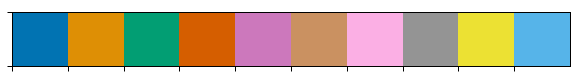

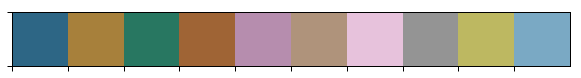

In [15]:
sns.palplot(cmap)
sns.palplot(cmap_l)

### Maiolino 

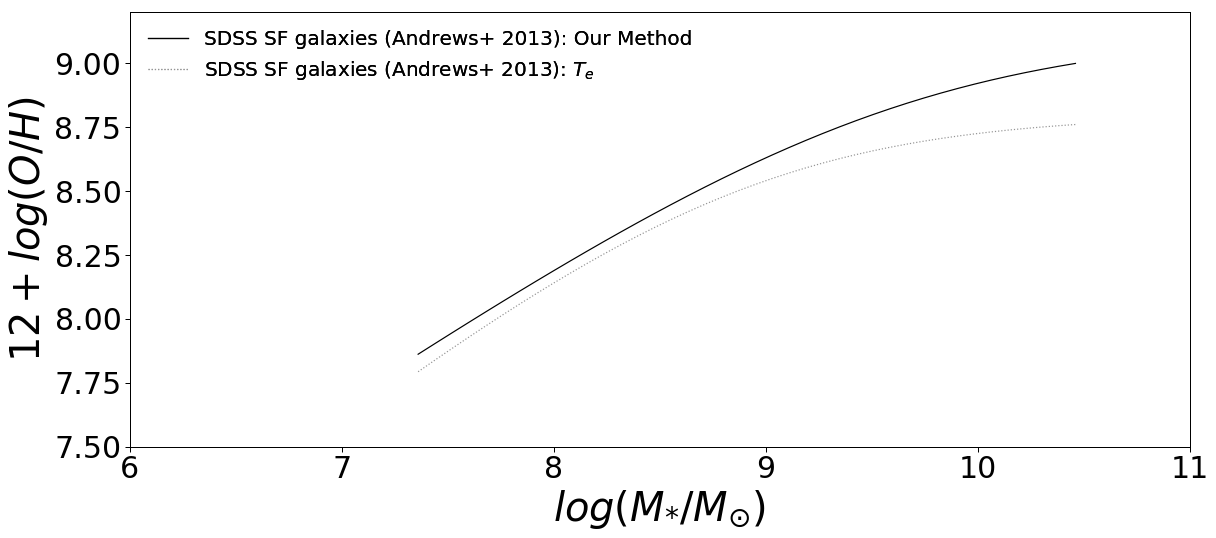

In [16]:
f, ax = plt.subplots(1,1,figsize=(19,8))

#plot SDSS curve 
mzr_d, = ax.plot(mass_range_cab, mzr_data, color='black', label='SDSS SF galaxies (Andrews+ 2013): Our Method')
mzr_p, = ax.plot(mass_range_cab, mzr_paper, color=cmap[7], ls=':', label='SDSS SF galaxies (Andrews+ 2013): $T_e$')

#plot setup
plt.tick_params(axis='both', which='major', labelsize=30)
ax.set_xlabel(r'$log(M_{*}/M_{\odot})$', fontsize=40)
ax.set_ylabel(r'$12+log(O/H)$', fontsize=40)

ax.set_ylim(7.5, 9.2)

ax.set_xlim(6.0,11.0)

legend_sdss = plt.legend(handles=[mzr_d, mzr_p], loc=2, fontsize=20, frameon=False)
ax.add_artist(legend_sdss)

#legend2 = plt.legend(handles=[o2_d, o3_d, o3_dn], loc=4, fontsize=20)
#ax.add_artist(legend2)

plt.savefig(os.path.join(plot_path, 'MCMC_mass_metallicity_mai_sdss_compare_only.pdf'), bbox_inches='tight')
plt.show()

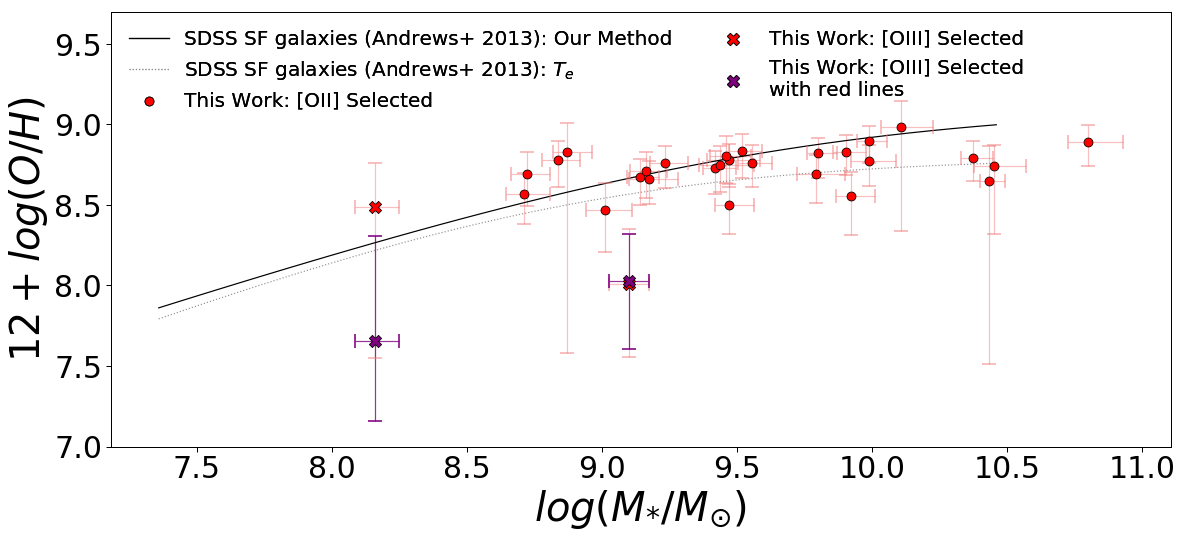

In [17]:
f, ax = plt.subplots(1,1,figsize=(19,8))

#plot SDSS curve 
mzr_d, = ax.plot(mass_range_cab, mzr_data, color='black', label='SDSS SF galaxies (Andrews+ 2013): Our Method')
mzr_p, = ax.plot(mass_range_cab, mzr_paper, color=cmap[7], ls=':', label='SDSS SF galaxies (Andrews+ 2013): $T_e$')

#This work Maiolino
o2_e = ax.errorbar(mass_all.iloc[0:27], met_all.iloc[0:27], yerr=(m_l_lis_all[0:27], m_u_lis_all[0:27]), xerr=(mass_e_lo_all[0:27], mass_e_up_all[0:27]), capsize=7, capthick=2, color='lightcoral', alpha=0.5, ls='None', label='_nolegend_')
o2_d = ax.scatter(mass_all.iloc[0:27], met_all.iloc[0:27], color='red', edgecolors='black', s=80, marker='o', label='This Work: [OII] Selected', zorder=1000)

o3_e = ax.errorbar(mass_all.iloc[27:29], met_all.iloc[27:29], yerr=(m_l_lis_all[27:29], m_u_lis_all[27:29]), xerr=(mass_e_lo_all[27:29], mass_e_up_all[27:29]), capsize=7, capthick=2, color='lightcoral', alpha=0.5, ls='None', label='_nolegend_')
o3_d = ax.scatter(mass_all.iloc[27:29], met_all.iloc[27:29], color='red', edgecolors='black', s=150, marker='X', label='This Work: [OIII] Selected', zorder=1000)

o3_en = ax.errorbar(mass_all.iloc[27:29], met_all_wRL.iloc[27:29], yerr=(m_l_lis_all_wRL[27:29], m_u_lis_all_wRL[27:29]), xerr=(mass_e_lo_all[27:29], mass_e_up_all[27:29]), capsize=7, capthick=2, color='purple', alpha=0.8, ls='None', label='_nolegend_')
o3_dn = ax.scatter(mass_all.iloc[27:29], met_all_wRL.iloc[27:29], color='purple', edgecolors='black', s=150, marker='X', label='This Work: [OIII] Selected '+'\n'+'with red lines', zorder=1000)

#plot setup
plt.tick_params(axis='both', which='major', labelsize=30)
ax.set_xlabel(r'$log(M_{*}/M_{\odot})$', fontsize=40)
ax.set_ylabel(r'$12+log(O/H)$', fontsize=40)

ax.set_ylim(7.0, 9.7)

#ax.set_xlim(6.0,11.0)

legend_sdss = plt.legend(handles=[mzr_d, mzr_p, o2_d, o3_d, o3_dn], loc=2, fontsize=20, ncol=2, frameon=False)
ax.add_artist(legend_sdss)

#legend2 = plt.legend(handles=[o2_d, o3_d, o3_dn], loc=4, fontsize=20)
#ax.add_artist(legend2)

plt.savefig(os.path.join(plot_path, 'MCMC_mass_metallicity_mai_sdss_only.pdf'), bbox_inches='tight')
plt.show()

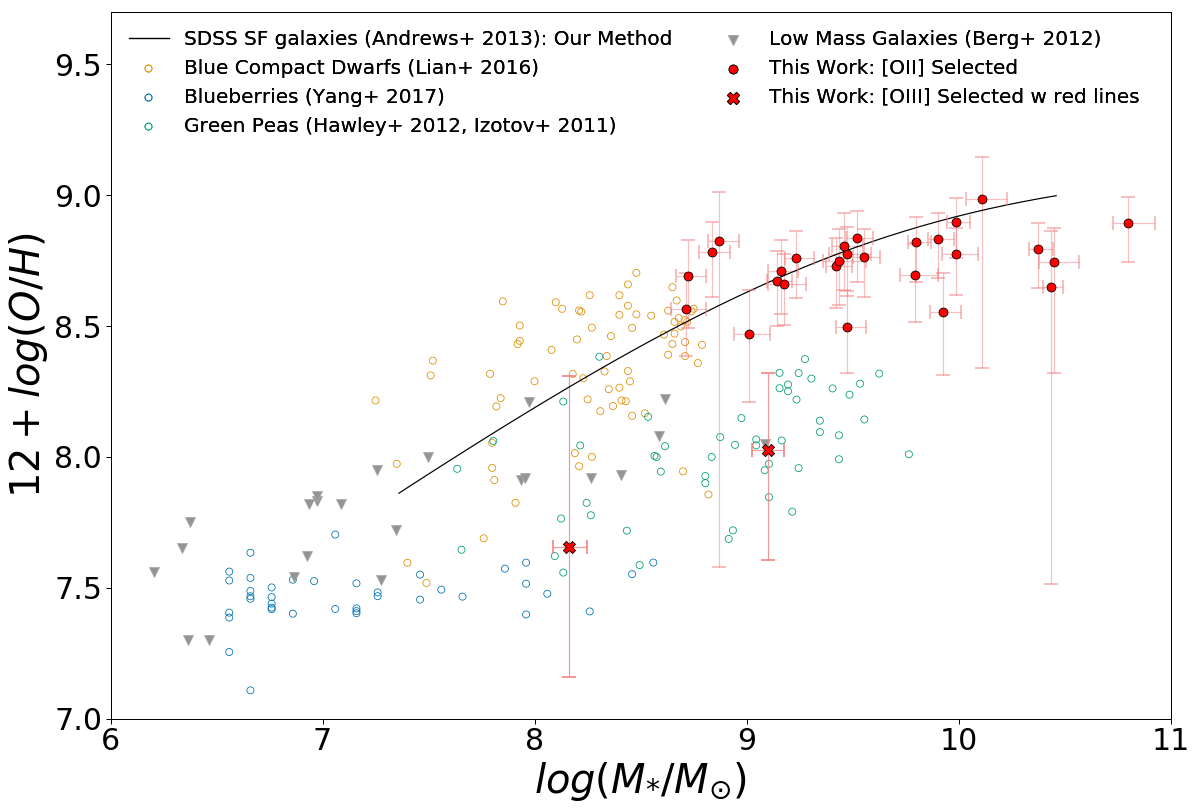

In [18]:
f, ax = plt.subplots(1,1,figsize=(19,13))

#plot other populations 
bcd = ax.scatter(bcd_mass_cab, bcd_metals, facecolors='none', edgecolors=cmap[1], s=50, alpha=1, label='Blue Compact Dwarfs (Lian+ 2016)')
bb  = ax.scatter(bb_mass_cab, bb_metals, facecolors='none', edgecolors=cmap[0], s=50, alpha=1, label='Blueberries (Yang+ 2017)')
gp  = ax.scatter(gp_mass_izotov_cab, gp_metals, facecolors='none', edgecolors=cmap[2], s=50, alpha=1, label='Green Peas (Hawley+ 2012, Izotov+ 2011)')
lmg = ax.scatter(lmg_mass_cab, lmg_metals, s=100, marker='v', facecolors=cmap[7], edgecolors='darkgrey', label='Low Mass Galaxies (Berg+ 2012)')

#plot SDSS curve 
mzr_d, = ax.plot(mass_range_cab, mzr_data, color='black', label='SDSS SF galaxies (Andrews+ 2013): Our Method')

#This work Maiolino
o2_e = ax.errorbar(mass_all.iloc[0:27], met_all.iloc[0:27], yerr=(m_l_lis_all[0:27], m_u_lis_all[0:27]), xerr=(mass_e_lo_all[0:27], mass_e_up_all[0:27]), capsize=7, capthick=2, color='lightcoral', alpha=0.5, ls='None', label='_nolegend_')
o2_d = ax.scatter(mass_all.iloc[0:27], met_all.iloc[0:27], color='red', edgecolors='black', s=80, marker='o', label='This Work: [OII] Selected', zorder=1000)

o3_en = ax.errorbar(mass_all.iloc[27:29], met_all_wRL.iloc[27:29], yerr=(m_l_lis_all_wRL[27:29], m_u_lis_all_wRL[27:29]), xerr=(mass_e_lo_all[27:29], mass_e_up_all[27:29]), capsize=7, capthick=2, color='lightcoral', alpha=0.8, ls='None', label='_nolegend_')
o3_dn = ax.scatter(mass_all.iloc[27:29], met_all_wRL.iloc[27:29], color='red', edgecolors='black', s=150, marker='X', label='This Work: [OIII] Selected w red lines', zorder=1000)

#plot setup
plt.tick_params(axis='both', which='major', labelsize=30)
ax.set_xlabel(r'$log(M_{*}/M_{\odot})$', fontsize=40)
ax.set_ylabel(r'$12+log(O/H)$', fontsize=40)

ax.set_ylim(7.0, 9.7)
ax.set_xlim(6.0,11.0)

legend1 = plt.legend(handles=[mzr_d, bcd, bb, gp, lmg, o2_d, o3_dn], loc=2, fontsize=20, ncol=2, frameon=False)
ax.add_artist(legend1)

#legend2 = plt.legend(handles=[o2_d, o3_d, o3_dn], loc=4, fontsize=20)
#ax.add_artist(legend2)

plt.savefig(os.path.join(plot_path, 'MCMC_mass_metallicity_mai.pdf'), bbox_inches='tight')
plt.show()

In [52]:
def build_obj_df(met, mass, met_e, mass_e, obj):
    obj_df = pd.DataFrame(columns=['Metallicity', 'log(M*)', 'Metallicity_error', 'Mass_error', 'Object_Type'])
    obj_df['Metallicity'] = met
    obj_df['log(M*)'] = mass
    obj_df['Metallicity_error'] = met_e
    obj_df['Mass_error'] = mass_e
    obj_df['Object_Type'] = obj
    return obj_df

hps_mass_e = [str((mass_e_lo_all[i], mass_e_up_all[i])) for i in range(len(mass_e_lo_all))]

plt_df_hpso2 = build_obj_df(met_all.iloc[0:27], mass_all.iloc[0:27], met_merge_all['met_err'][0:27], hps_mass_e[0:27], 'HPS_OII')
plt_df_hpso3 = build_obj_df(met_all_wRL.iloc[27:29], mass_all.iloc[27:29], met_merge_all['met_err_wRL'][27:29], hps_mass_e[27:29], 'HPS_OIII')
plt_df_gp    = build_obj_df(gp_metals, gp_mass_izotov_cab, gp_merge['met_err'], None, 'Green_Pea')
plt_df_bb    = build_obj_df(bb_metals, bb_mass_cab, bb_merge['met_err'], None, 'Blueberry')
plt_df_bcd   = build_obj_df(bcd_metals, bcd_mass_cab, bcd['met_err'], None, 'Blue_Compact_Dwarf')
plt_df_lmg   = build_obj_df(lmg_metals, lmg_mass_cab, lmg['12+log(O/H)_e'], None, 'Low_Mass_Galaxy')
plt_df_sdss  = build_obj_df(mzr_data, mass_range_cab, None, None, 'SDSS_SF_Galaxies')

frames = [plt_df_hpso2, plt_df_hpso3, plt_df_sdss, plt_df_gp, plt_df_bb, plt_df_bcd, plt_df_lmg]
mzr_plt_data = pd.concat(frames)
mzr_plt_data.to_csv(plot_path+'/MCMC_mass_metallicity_mai_data.csv')

### Maiolino w/ NeIII

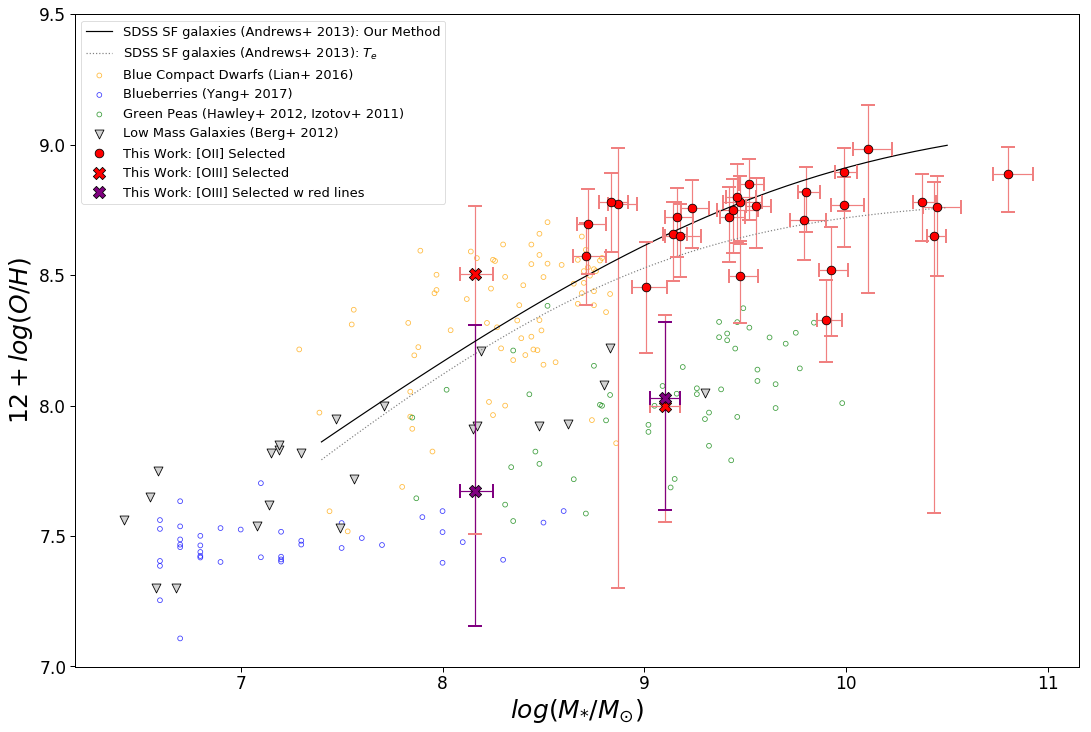

In [19]:
plt.figure(figsize=(18,12))

#plot other populations 
plt.scatter(bcd_mass, bcd_metals, facecolors='none', edgecolors='orange', alpha=0.75, label='Blue Compact Dwarfs (Lian+ 2016)')
plt.scatter(bb_mass, bb_metals, facecolors='none', edgecolors='blue', alpha=0.75, label='Blueberries (Yang+ 2017)')
plt.scatter(gp_mass_izotov, gp_metals, facecolors='none', edgecolors='green', alpha=0.75, label='Green Peas (Hawley+ 2012, Izotov+ 2011)')
plt.scatter(lmg_mass, lmg_metals, s=80, marker='v', facecolors='lightgrey', edgecolors='black', label='Low Mass Galaxies (Berg+ 2012)')

#plot SDSS curve 
plt.plot(mass_range, mzr_data, color='black', label='SDSS SF galaxies (Andrews+ 2013): Our Method')
plt.plot(mass_range, mzr_paper, color='grey', ls=':',label='SDSS SF galaxies (Andrews+ 2013): $T_e$')

#This work Maiolino
plt.errorbar(mass_all.iloc[0:27], met_all_wNe.iloc[0:27], yerr=(m_l_lis_all_wNe[0:27], m_u_lis_all_wNe[0:27]), xerr=(mass_e_lo_all[0:27], mass_e_up_all[0:27]), capsize=7, capthick=2, color='lightcoral', ls='None', label='_nolegend_')
plt.scatter(mass_all.iloc[0:27], met_all_wNe.iloc[0:27], color='red', edgecolors='black', s=75, marker='o', label='This Work: [OII] Selected', zorder=1000)

plt.errorbar(mass_all.iloc[27:29], met_all_wNe.iloc[27:29], yerr=(m_l_lis_all_wNe[27:29], m_u_lis_all_wNe[27:29]), xerr=(mass_e_lo_all[27:29], mass_e_up_all[27:29]), capsize=7, capthick=2, color='lightcoral', ls='None', label='_nolegend_')
plt.scatter(mass_all.iloc[27:29], met_all_wNe.iloc[27:29], color='red', edgecolors='black', s=150, marker='X', label='This Work: [OIII] Selected', zorder=1000)

plt.errorbar(mass_all.iloc[27:29], met_all_wNe_wRL.iloc[27:29], yerr=(m_l_lis_all_wNe_wRL[27:29], m_u_lis_all_wNe_wRL[27:29]), xerr=(mass_e_lo_all[27:29], mass_e_up_all[27:29]), capsize=7, capthick=2, color='purple', ls='None', label='_nolegend_')
plt.scatter(mass_all.iloc[27:29], met_all_wNe_wRL.iloc[27:29], color='purple', edgecolors='black', s=150, marker='X', label='This Work: [OIII] Selected w red lines', zorder=1000)

#plot setup
plt.tick_params(axis='both', which='major', labelsize=17)
plt.xlabel(r'$log(M_{*}/M_{\odot})$', fontsize=25)
plt.ylabel(r'$12+log(O/H)$', fontsize=25)

plt.ylim(7.0, 9.5)

plt.legend(loc=2, fontsize=13)
plt.savefig(os.path.join(plot_path, 'MCMC_mass_metallicity_mai_wNe.png'))
plt.show()

### Curti

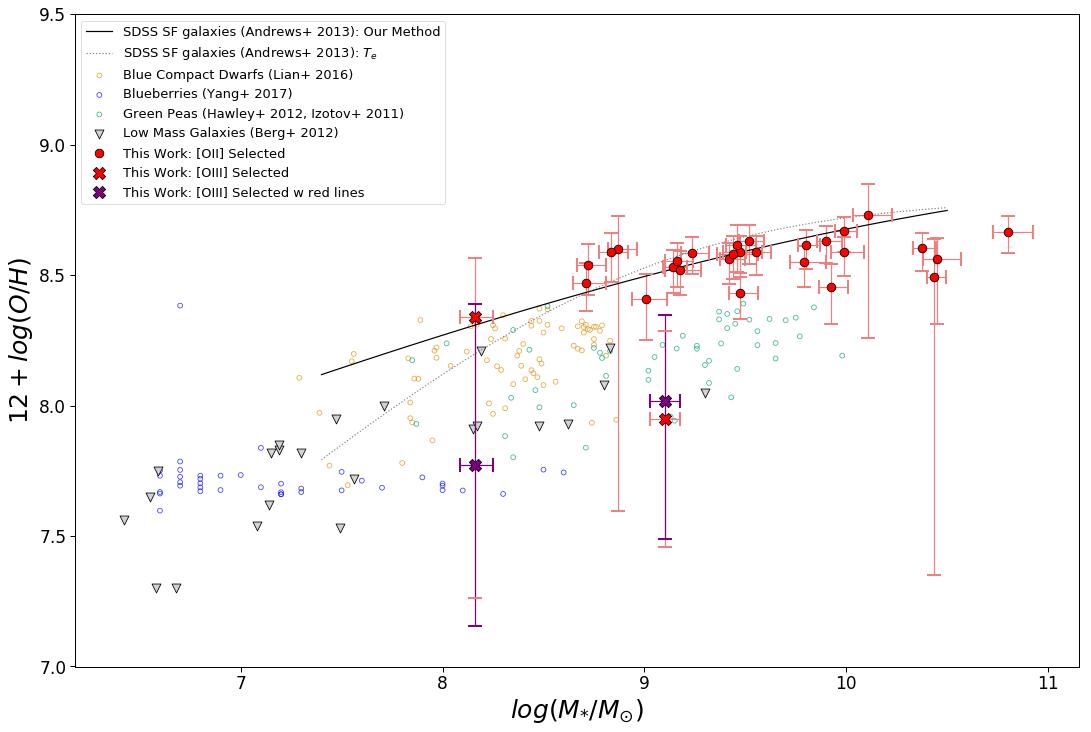

In [20]:
plt.figure(figsize=(18,12))

#plot other populations 
plt.scatter(bcd_mass, bcd_metals_c, facecolors='none', edgecolors=cmap[1], alpha=0.75, label='Blue Compact Dwarfs (Lian+ 2016)')
plt.scatter(bb_mass, bb_metals_c, facecolors='none', edgecolors='blue', alpha=0.75, label='Blueberries (Yang+ 2017)')
plt.scatter(gp_mass_izotov, gp_metals_c, facecolors='none', edgecolors=cmap[2], alpha=0.75, label='Green Peas (Hawley+ 2012, Izotov+ 2011)')
plt.scatter(lmg_mass, lmg_metals, s=80, marker='v', facecolors='lightgrey', edgecolors='black', label='Low Mass Galaxies (Berg+ 2012)')

#plot SDSS curve 
plt.plot(mass_range, mzr_data_c, color='black', label='SDSS SF galaxies (Andrews+ 2013): Our Method')
plt.plot(mass_range, mzr_paper, color='grey', ls=':',label='SDSS SF galaxies (Andrews+ 2013): $T_e$')

#This work Curti
plt.errorbar(mass_all.iloc[0:27], met_all_c.iloc[0:27], yerr=(m_l_lis_all_c[0:27], m_u_lis_all_c[0:27]), xerr=(mass_e_lo_all[0:27], mass_e_up_all[0:27]), capsize=7, capthick=2, color='lightcoral', ls='None', label='_nolegend_')
plt.errorbar(mass_all.iloc[27:29], met_all_c.iloc[27:29], yerr=(m_l_lis_all_c[27:29], m_u_lis_all_c[27:29]), xerr=(mass_e_lo_all[27:29], mass_e_up_all[27:29]), capsize=7, capthick=2, color='lightcoral', ls='None', label='_nolegend_')

plt.scatter(mass_all.iloc[0:27], met_all_c.iloc[0:27], color='red', edgecolors='black', s=75, marker='o', label='This Work: [OII] Selected', zorder=1000)
plt.scatter(mass_all.iloc[27:29], met_all_c.iloc[27:29], color='red', edgecolors='black', s=150, marker='X', label='This Work: [OIII] Selected', zorder=1000)

plt.errorbar(mass_all.iloc[27:29], met_all_wRL_c.iloc[27:29], yerr=(m_l_lis_all_wRL_c[27:29], m_u_lis_all_wRL_c[27:29]), xerr=(mass_e_lo_all[27:29], mass_e_up_all[27:29]), capsize=7, capthick=2, color='purple', ls='None', label='_nolegend_')
plt.scatter(mass_all.iloc[27:29], met_all_wRL_c.iloc[27:29], color='purple', edgecolors='black', s=150, marker='X', label='This Work: [OIII] Selected w red lines', zorder=1000)

#plot setup
plt.tick_params(axis='both', which='major', labelsize=17)
plt.xlabel(r'$log(M_{*}/M_{\odot})$', fontsize=25)
plt.ylabel(r'$12+log(O/H)$', fontsize=25)

plt.ylim(7.0, 9.5)

plt.legend(loc=2, fontsize=13)
plt.savefig(os.path.join(plot_path, 'MCMC_mass_metallicity_curti.png'))
plt.show()

# MZR result comparisons

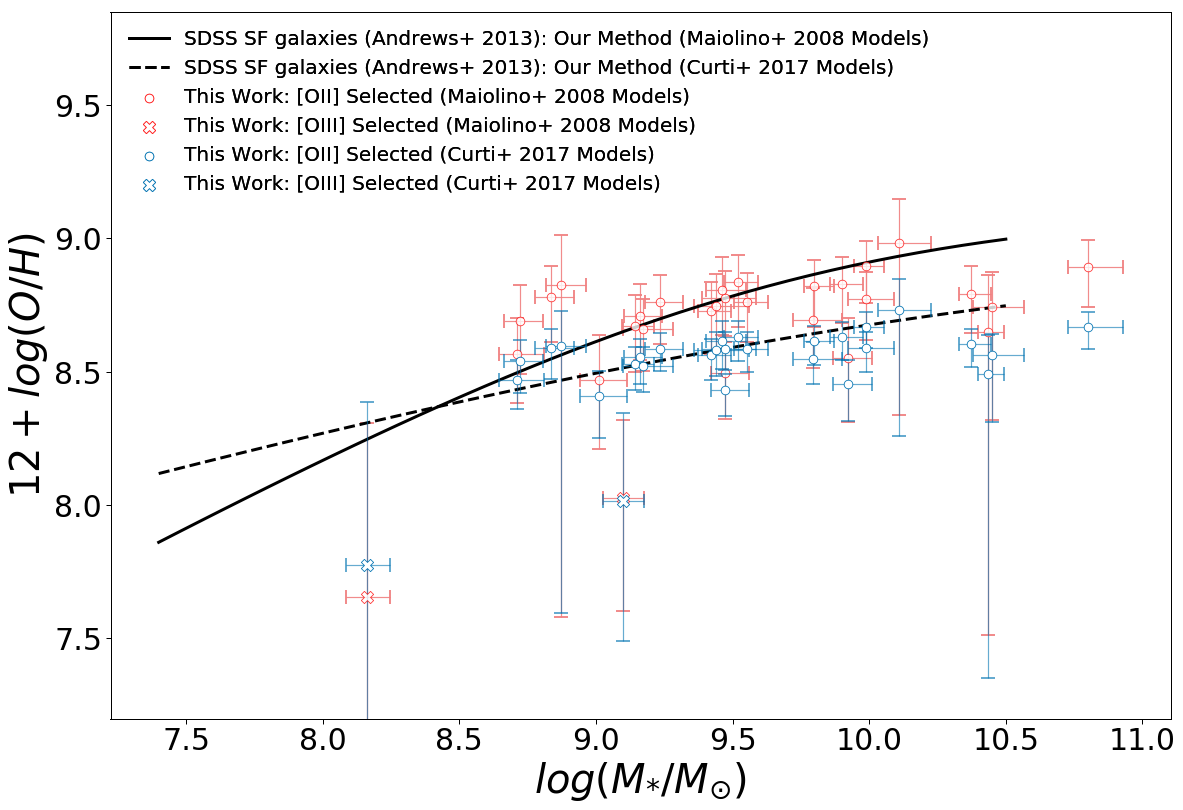

In [30]:
f, ax = plt.subplots(1,1,figsize=(19,13))

#This work Curti 
co2e = ax.errorbar(mass_all.iloc[0:27], met_all_c.iloc[0:27], yerr=(m_l_lis_all_c[0:27], m_u_lis_all_c[0:27]), xerr=(mass_e_lo_all[0:27], mass_e_up_all[0:27]), capsize=7, capthick=2, color=cmap[0], alpha=0.6, ls='None', label='_nolegend_',zorder=1000)
co2d = ax.scatter(mass_all.iloc[0:27], met_all_c.iloc[0:27], color='white', alpha=1.0, edgecolors=cmap[0], s=75, marker='o', label='This Work: [OII] Selected (Curti+ 2017 Models)',zorder=2001)

co3e = ax.errorbar(mass_all.iloc[27:29], met_all_wRL_c.iloc[27:29], yerr=(m_l_lis_all_wRL_c[27:29], m_u_lis_all_wRL_c[27:29]), xerr=(mass_e_lo_all[27:29], mass_e_up_all[27:29]), capsize=7, capthick=2, color=cmap[0], alpha=0.6, ls='None', label='_nolegend_',zorder=1000)
co3d = ax.scatter(mass_all.iloc[27:29], met_all_wRL_c.iloc[27:29], color='white', alpha=1.0, edgecolors=cmap[0], s=150, marker='X', label='This Work: [OIII] Selected (Curti+ 2017 Models)',zorder=2001)

#This work Maiolino
mo2e = ax.errorbar(mass_all.iloc[0:27], met_all.iloc[0:27], yerr=(m_l_lis_all[0:27], m_u_lis_all[0:27]), xerr=(mass_e_lo_all[0:27], mass_e_up_all[0:27]), capsize=7, capthick=2, color='lightcoral', alpha=0.9, ls='None', label='_nolegend_')
mo2d = ax.scatter(mass_all.iloc[0:27], met_all.iloc[0:27], color='white', alpha=0.8, edgecolors='red', s=75, marker='o', label='This Work: [OII] Selected (Maiolino+ 2008 Models)',zorder=1000)

mo3e = ax.errorbar(mass_all.iloc[27:29], met_all_wRL.iloc[27:29], yerr=(m_l_lis_all_wRL[27:29], m_u_lis_all_wRL[27:29]), xerr=(mass_e_lo_all[27:29], mass_e_up_all[27:29]), capsize=7, capthick=2, color='lightcoral', alpha=0.9, ls='None', label='_nolegend_')
mo3d = ax.scatter(mass_all.iloc[27:29], met_all_wRL.iloc[27:29], color='white', alpha=0.8, edgecolors='red', s=150, marker='X', label='This Work: [OIII] Selected (Maiolino+ 2008 Models)',zorder=1000)


#plot SDSS curve 
mzr_dm, = ax.plot(mass_range, mzr_data, color='black', lw=3, label='SDSS SF galaxies (Andrews+ 2013): Our Method (Maiolino+ 2008 Models)')
mzr_dc, = ax.plot(mass_range, mzr_data_c, color='black', lw=3, ls='--',label='SDSS SF galaxies (Andrews+ 2013): Our Method (Curti+ 2017 Models)')
#mzr_p,  = ax.plot(mass_range, mzr_paper, color='grey', lw=3, ls=':',label='SDSS SF galaxies (Andrews+ 2013): $T_e$')

#plot setup
plt.tick_params(axis='both', which='major', labelsize=30)
ax.set_xlabel(r'$log(M_{*}/M_{\odot})$', fontsize=40)
ax.set_ylabel(r'$12+log(O/H)$', fontsize=40)

ax.set_ylim(7.2, 9.85)

legend1 = plt.legend(handles=[mzr_dm, mzr_dc, mo2d, mo3d, co2d, co3d], loc=2, fontsize=20, frameon=False)
ax.add_artist(legend1)

plt.savefig(os.path.join(plot_path, 'MCMC_mass_metallicity_maio_curt_compare.pdf'), bbox_inches='tight')
plt.show()

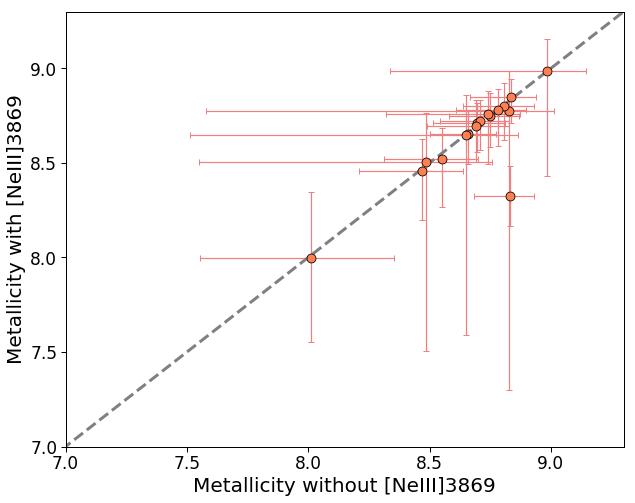

In [31]:
hps_props = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_all_props.csv')
hps_props = hps_props.loc[:,['HPS_name', 'Source']]
met_props_merge = pd.merge(met_merge_all, hps_props, on='HPS_name', how='left')
met_props_merge = pd.merge(met_props_merge, hps_fluxes.loc[:,['HPS_name','[NeIII]3870']], on='HPS_name', how='left')
lrs2_wNe = met_props_merge[~np.isnan(met_props_merge['[NeIII]3870'])].loc[:,['HPS_name', 'Source','[NeIII]3870', 'metallicity', 'metallicity_wNe', 'met_err_u', 'met_err_l', 'met_err_u_wNe', 'met_err_l_wNe']]

fig, ax = plt.subplots(figsize=(10,8))

ax.errorbar(lrs2_wNe['metallicity'], lrs2_wNe['metallicity_wNe'], xerr=(lrs2_wNe['met_err_l'],lrs2_wNe['met_err_u']), yerr=(lrs2_wNe['met_err_l_wNe'],lrs2_wNe['met_err_u_wNe']), capsize=3, capthick=1, color='lightcoral', ls='None', label='_nolegend_')
ax.scatter(lrs2_wNe['metallicity'], lrs2_wNe['metallicity_wNe'], s=80, edgecolors='black', color='coral', zorder=1000)
x_vals = np.arange(6.5, 10.0)
ax.plot(x_vals, x_vals, color='grey', ls='--', lw=3)

ax.set_xlim(7.0, 9.3)
ax.set_ylim(7.0, 9.3)

plt.tick_params(axis='both', which='major', labelsize=17)
ax.set_ylabel('Metallicity with [NeIII]3869', fontsize=20)
ax.set_xlabel('Metallicity without [NeIII]3869', fontsize=20)

plt.savefig(os.path.join(plot_path, 'met_compare_wNe.png'))
plt.show()

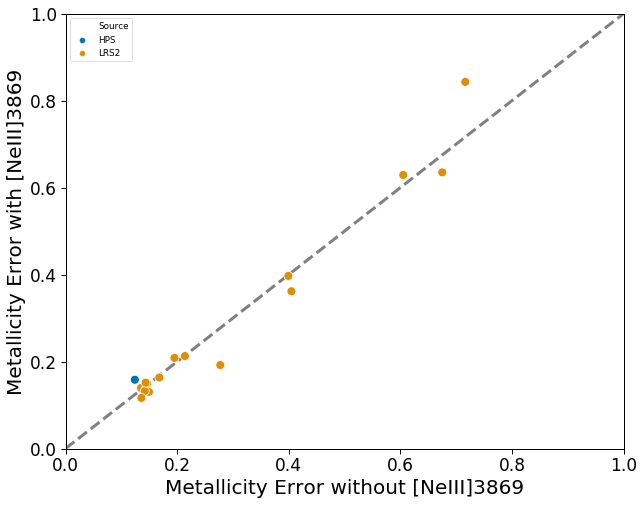

In [32]:
lrs2_wNe['met_e_avg'] = (lrs2_wNe['met_err_l'] + lrs2_wNe['met_err_u'])/2.0
lrs2_wNe['met_e_avg_wNe'] = (lrs2_wNe['met_err_l_wNe'] + lrs2_wNe['met_err_u_wNe'])/2.0

fig, ax = plt.subplots(figsize=(10,8))

ax = sns.scatterplot(x="met_e_avg", y="met_e_avg_wNe", hue="Source",s=80, edgecolors='black', data=lrs2_wNe, zorder=1000
                    )
x_vals = np.arange(0.0, 1.5, 0.1)
ax.plot(x_vals, x_vals, color='grey', ls='--', lw=3)

ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

plt.tick_params(axis='both', which='major', labelsize=17)
ax.set_ylabel('Metallicity Error with [NeIII]3869', fontsize=20)
ax.set_xlabel('Metallicity Error without [NeIII]3869', fontsize=20)

plt.savefig(os.path.join(plot_path, 'met_compare_err_wNe.png'))
plt.show()

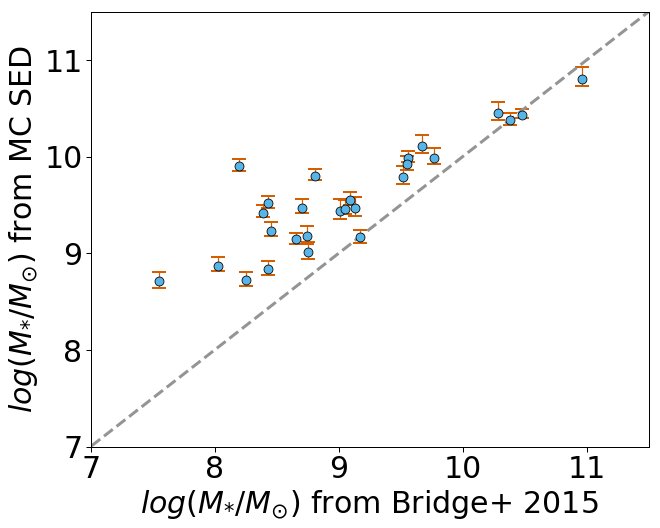

In [33]:
plt.figure(figsize=(10,8))

plt.errorbar(mass_bridge, mass_greg, yerr=(mass_e_lo, mass_e_up), capsize=7, capthick=2, color=cmap[3], ls='None', label='_nolegend_')
plt.scatter(mass_bridge, mass_greg, s=80, edgecolors='black', color=cmap[9], label='MC SED Masses', zorder=1000, )

x_vals = np.arange(6.5, 12.0)
# m = mass_fit[0][0]
# b = mass_fit[1][0]

# print m, b
# print (m*x_vals)+b
#plt.plot(x_vals, (m*x_vals)+b, color='green' )
plt.plot(x_vals, x_vals, color=cmap[7], ls='--', lw=3)

plt.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r'$log(M_{*}/M_{\odot})$'+' from Bridge+ 2015', fontsize=30)
plt.ylabel(r'$log(M_{*}/M_{\odot})$'+' from MC SED', fontsize=30)

plt.ylim(7.0, 11.5)
plt.xlim(7.0, 11.5)

plt.savefig(os.path.join(plot_path, 'greg_vs_bridge_mass.pdf'), bbox_inches='tight')
plt.show()

# Average metallicity from stack of chains

In [40]:
met_stack_mOII = '/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/sample_stack_maiolino_OII.txt'
ms = np.loadtxt(met_stack_mOII)
ndim = 3

print np.shape(ms)

results = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                zip(*np.percentile(ms, [16, 50, 84], axis=0)))

if ndim == 3: 
    names = ['Log (12 + O/H)', 'E(B-V)', 'OIII intrinsic']
elif ndim == 4:
    names = ['Log (12 + O/H)', 'E(B-V)', 'OIII intrinsic', r'H$\alpha$ intrinsic']            
plt.figure(figsize=(15,15))
fig = corner.corner(ms, labels=names,
                    truths=[r[0] for r in results], truth_color='lightcoral',
                    label_kwargs={"fontsize": 18}, show_titles=True,
                    title_kwargs={"fontsize": 16},
                    quantiles=[0.16, 0.5, 0.84], bins=30)
    
plt.savefig(op.join(os.path.join(plot_path, 'tot_mOII_cornerplot.png')))
plt.show()

KeyboardInterrupt: 

# Compare different populations

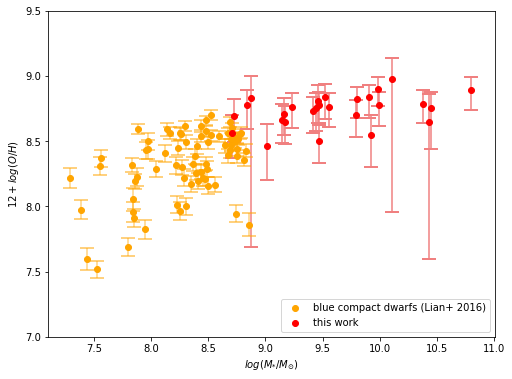

In [61]:
#Blue Compact Dwarfs compared to HPS
m_u_lis_bcd = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in bcd['met_err'].values]
m_l_lis_bcd = [float(s.split(s.split(l,']')[0], ',')[1]) for l in bcd['met_err'].values]

plt.figure(figsize=(8,6))
plt.errorbar(bcd_mass, bcd_metals, yerr=(m_l_lis_bcd, m_u_lis_bcd), capsize=7, capthick=2, color='orange', alpha=0.5, ls='None', label='_nolegend_')
plt.scatter(bcd_mass, bcd_metals, color='orange',  label='blue compact dwarfs (Lian+ 2016)', zorder=1000)

plt.errorbar(mass_greg, met_greg, yerr=(m_l_lis_g, m_u_lis_g), capsize=7, capthick=2, color='lightcoral', ls='None', label='_nolegend_')
plt.scatter(mass_greg, met_greg, color='red', label='this work', zorder=1000)

plt.xlabel(r'$log(M_{*}/M_{\odot})$')
plt.ylabel(r'$12+log(O/H)$')

plt.ylim(7.0, 9.5)

plt.legend(loc=4)
#plt.savefig(os.path.join(plot_path, 'bcd_compare.png'))
plt.show()

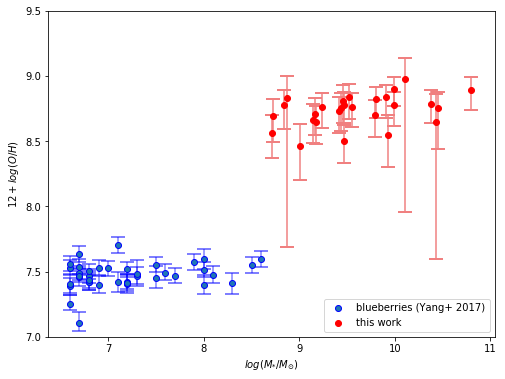

In [62]:
#Blueberries compared to HPS

m_u_lis_bb = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in bb['met_err'].values]
m_l_lis_bb = [float(s.split(s.split(l,']')[0], ',')[1]) for l in bb['met_err'].values]

plt.figure(figsize=(8,6))
plt.errorbar(bb_mass, bb_metals, yerr=(m_l_lis_bb, m_u_lis_bb),capsize=7, capthick=2, color='blue',alpha=0.5, ls='None', label='_nolegend_')
plt.scatter(bb_mass, bb_metals, edgecolors='blue', label='blueberries (Yang+ 2017)', zorder=1000)

plt.errorbar(mass_greg, met_greg, yerr=(m_l_lis_g, m_u_lis_g), capsize=7, capthick=2, color='lightcoral', ls='None', label='_nolegend_')
plt.scatter(mass_greg, met_greg, color='red', label='this work', zorder=1000)

plt.xlabel(r'$log(M_{*}/M_{\odot})$')
plt.ylabel(r'$12+log(O/H)$')

plt.ylim(7.0, 9.5)

plt.legend(loc=4)
#plt.savefig(os.path.join(plot_path, 'bb_compare.png'))
plt.show()

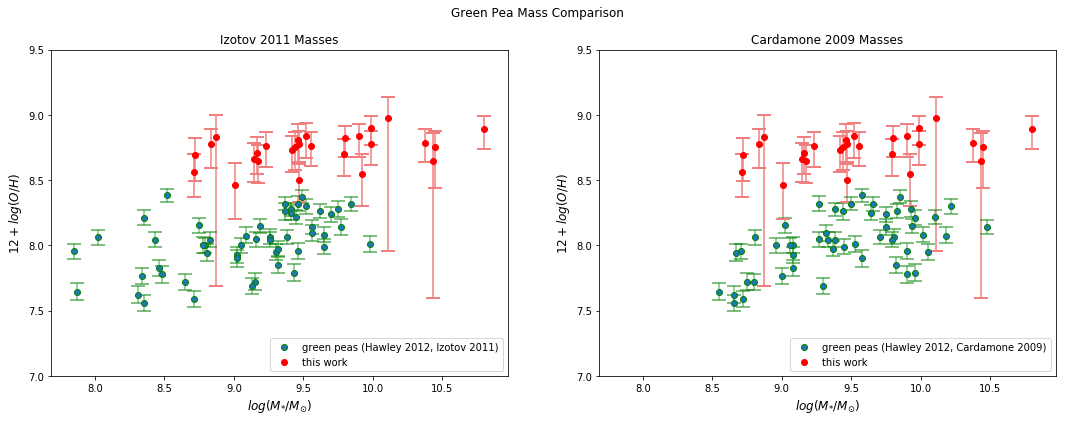

In [63]:
#Green Peas compared to HPS
m_u_lis_gp = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in gp_merge['met_err'].values]
m_l_lis_gp = [float(s.split(s.split(l,']')[0], ',')[1]) for l in gp_merge['met_err'].values]

f, ax = plt.subplots(1, 2, sharex=True, figsize=(18, 6))
f.suptitle('Green Pea Mass Comparison')

ax[0].set_title('Izotov 2011 Masses')
ax[0].errorbar(gp_mass_izotov, gp_metals, yerr=(m_l_lis_gp, m_u_lis_gp),capsize=7, capthick=2, color='green',alpha=0.5, ls='None', label='_nolegend_')
ax[0].scatter(gp_mass_izotov, gp_metals, edgecolors='green', label='green peas (Hawley 2012, Izotov 2011)', zorder=1000)

ax[1].set_title('Cardamone 2009 Masses')
ax[1].errorbar(gp_mass_card, gp_metals, yerr=(m_l_lis_gp, m_u_lis_gp),capsize=7, capthick=2, color='green',alpha=0.5, ls='None', label='_nolegend_')
ax[1].scatter(gp_mass_card, gp_metals, edgecolors='green', label='green peas (Hawley 2012, Cardamone 2009)', zorder=1000)

for i in range(len(ax)):
    
    ax[i].errorbar(mass_greg, met_greg, yerr=(m_l_lis_g, m_u_lis_g), capsize=7, capthick=2, color='lightcoral', ls='None', label='_nolegend_')
    ax[i].scatter(mass_greg, met_greg, color='red', label='this work', zorder=1000)
    
    ax[i].set_xlabel(r'$log(M_{*}/M_{\odot})$',fontsize='large', fontweight='bold')
    ax[i].set_ylabel(r'$12+log(O/H)$',fontsize='large', fontweight='bold')

    ax[i].set_ylim(7.0, 9.5)
    ax[i].legend(loc=4)

#plt.savefig(os.path.join(plot_path, 'gp_compare.png'))
plt.show()

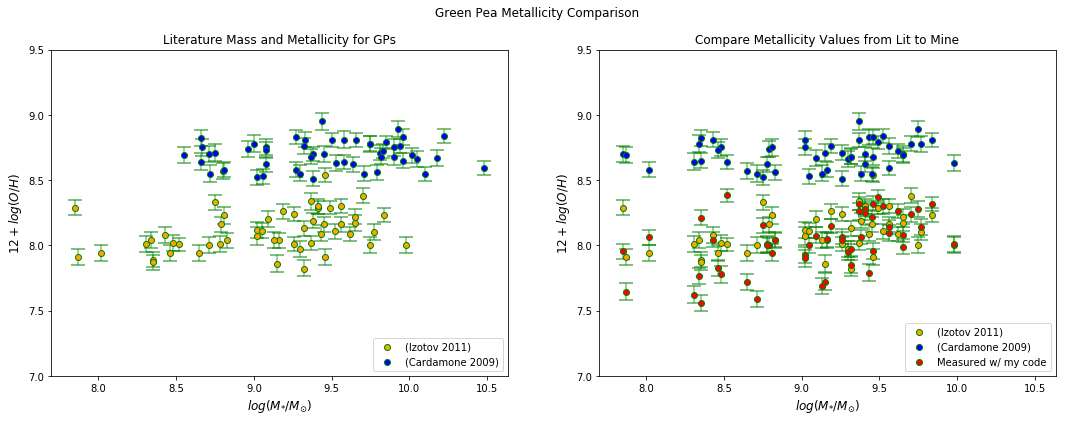

In [64]:
#compare the literature GP values to my measured metallicities

f, ax = plt.subplots(1, 2, sharex=True, figsize=(18, 6))
f.suptitle('Green Pea Metallicity Comparison')

ax[0].set_title('Literature Mass and Metallicity for GPs')
ax[0].errorbar(gp_mass_izotov, gp_metals_izotov, yerr=(m_l_lis_gp, m_u_lis_gp),capsize=7, capthick=2, color='green',alpha=0.5, ls='None', label='_nolegend_')
ax[0].scatter(gp_mass_izotov, gp_metals_izotov, color='orange', edgecolors='green', label='(Izotov 2011)', zorder=1000)

ax[0].errorbar(gp_mass_card, gp_metals_card, yerr=(m_l_lis_gp, m_u_lis_gp),capsize=7, capthick=2, color='green',alpha=0.5, ls='None', label='_nolegend_')
ax[0].scatter(gp_mass_card, gp_metals_card, color='blue', edgecolors='green', label='(Cardamone 2009)', zorder=1000)

ax[1].set_title('Compare Metallicity Values from Lit to Mine')
ax[1].errorbar(gp_mass_izotov, gp_metals_izotov, yerr=(m_l_lis_gp, m_u_lis_gp),capsize=7, capthick=2, color='green',alpha=0.5, ls='None', label='_nolegend_')
ax[1].scatter(gp_mass_izotov, gp_metals_izotov, color='orange', edgecolors='green', label='(Izotov 2011)', zorder=1000)

ax[1].errorbar(gp_mass_izotov, gp_metals_card, yerr=(m_l_lis_gp, m_u_lis_gp),capsize=7, capthick=2, color='green',alpha=0.5, ls='None', label='_nolegend_')
ax[1].scatter(gp_mass_izotov, gp_metals_card, color='blue', edgecolors='green', label='(Cardamone 2009)', zorder=1000)

ax[1].errorbar(gp_mass_izotov, gp_metals, yerr=(m_l_lis_gp, m_u_lis_gp),capsize=7, capthick=2, color='green',alpha=0.5, ls='None', label='_nolegend_')
ax[1].scatter(gp_mass_izotov, gp_metals, color='red', edgecolors='green', label='Measured w/ my code', zorder=1000)

for i in range(len(ax)):
    ax[i].set_xlabel(r'$log(M_{*}/M_{\odot})$',fontsize='large', fontweight='bold')
    ax[i].set_ylabel(r'$12+log(O/H)$',fontsize='large', fontweight='bold')

    ax[i].set_ylim(7.0, 9.5)
    ax[i].legend(loc=4)

#plt.savefig(os.path.join(plot_path, 'gp_lit_vs_measured.png'))
plt.show()

# Plot HPS points on Maolino (and Curti) relations

In [34]:
#Functions defining the reddening

#define Calzetti law 2000 
#wl in angstroms
def calzetti(wl):
    wl = wl/10000.
    if wl <= 6300:
        return 2.695*(-2.156+(1.509/wl)-(0.189/(wl**2))+(0.011/(wl**3)))+4.05
    else:
        return 2.659*(-1.857+(1.040/wl))+4.05

def reddening(wl, E_bv):
    return 10**(0.4*E_bv*calzetti(wl))

def reddening_err(wl, E_bv, E_bv_e):
    dr = np.sqrt((0.4*calzetti(wl)*np.log(10)*(10**(0.4*E_bv*calzetti(wl)))*E_bv_e)**2)
    return dr

print 2.44*reddening(5007, 0.51)

20.8394458995


In [35]:
#Functions defining the Maolino relations

def O3O2_model(x):
    r_O32 = -0.2839+(-1.3881*x)+(-0.3172*(x**2))
    return 10**r_O32

def R23_model(x):
    r_23 = 0.7462+(-0.7149*x)+(-0.9401*(x**2))+(-0.6154*(x**3))+(-0.2524*(x**4))
    return 10**r_23

def Ne3O2_model(x):
    neo2 = -1.2608+(-1.0861*x)+(-0.1470*(x**2))
    return 10**neo2

def N2_model(x):
    n2 = -0.7732 + (1.2357*x) + (-0.2811*(x**2)) + (-0.7201*(x**2)) + (-0.3330*(x**4))
    return 10**n2
    
def O3N2_model(x):
    o3n2 = 0.4520 + (-2.6096*x) + (-0.7170*(x**2)) + (0.1347*(x**3))
    return 10**o3n2

#Functions for Curti 2017 Models 

def O3O2_model_c(x):
    r_O32 = -0.691+(-2.944*x)+(-1.308*(x**2))
    return 10**r_O32

def R23_model_c(x):
    r_23 = 0.527+(-1.569*x)+(-1.652*(x**2))+(-0.421*(x**3))
    return 10**r_23

def N2_model_c(x):
    n2 = -0.489 + (1.513*x) + (-2.554*(x**2)) + (-5.293*(x**2)) + (-2.867*(x**4))
    return 10**n2

In [36]:
#Functions defining observed ratios

def O3O2_ratio(OIII, OII, E_bv):
    return (OIII*reddening(5007, E_bv))/(OII*reddening(3727, E_bv))

def R23_ratio(OIII, OII, Hb, E_bv):
    return ((OII*reddening(3727, E_bv))+((OIII*reddening(5007, E_bv))*(1+(1/2.98))))/(Hb*reddening(4861, E_bv))

def Ne3O2_ratio(NeIII, OII, E_bv):
    return (NeIII*reddening(3869, E_bv))/(OII*reddening(3727, E_bv))

def N2_ratio(NII, Ha, E_bv):
    return (NII*reddening(6583, E_bv))/(Ha*reddening(6562, E_bv))

def O3N2_ratio(OIII, NII, E_bv):
    return (OIII*reddening(5007, E_bv))/(NII*reddening(6583, E_bv))

In [37]:
# Fuctions defining observed ratio errors

def O3O2(OIII, OII):
    return OIII/OII

def R23(OIII, OII, Hb):
    return (OIII*(1+(1/2.98)) + OII) / Hb

def O3O2_e(OIII, OII, OIII_e, OII_e):
    rat = O3O2(OIII, OII)
    do3o2 = np.abs(rat)*np.sqrt(((OIII_e/OIII)**2)+((OII_e/OII)**2))
    return do3o2

def R23_e(OIII, OII, Hb, OIII_e, OII_e, Hb_e):
    rat = R23(OIII, OII, Hb)
    dr23 = np.sqrt(((((1+(1/2.98))/Hb)*OIII_e)**2)+
                   (((1/Hb)*OII_e)**2)+
                   ((((OIII*(1+(1/2.98))+OII)/(Hb**2))*Hb_e)**2))
    return dr23

In [38]:
# Fuctions defining observed ratio errors with E(B-V) error 
def O3O2_e_wR(OIII, OII, OIII_e, OII_e, E_bv, E_bv_e):
    rat = O3O2(OIII, OII, E_bv)
    do3o2 = np.abs(rat)*np.sqrt(((OIII_e/OIII)**2)+((OII_e/OII)**2))
    return do3o2

In [39]:
# Fuctions defining observed ratio errors with E(B-V) error 

def O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv, E_bv_e):
    k_5007 = calzetti(5007)
    k_3727 = calzetti(3727)
    e_5007 = reddening(5007, E_bv)
    e_3727 = reddening(3727, E_bv)
    e_3727_e = reddening_err(3727, E_bv, E_bv_e)
    e_5007_e = reddening_err(5007, E_bv, E_bv_e)
    rat = O3O2_ratio(OIII, OII, E_bv)
    do3o2  = np.abs(rat)*np.sqrt(((OIII_e/OIII)**2)+((OII_e/OII)**2)+((e_5007_e/e_5007)**2)+((e_3727_e/e_3727)**2))
    return do3o2

def R23_ratio_err(OIII, OII, Hb, OIII_e, OII_e, Hb_e, E_bv, E_bv_e):
    k_5007 = calzetti(5007)
    k_3727 = calzetti(3727)
    k_4861 = calzetti(4861)
    e_5007 = reddening(5007, E_bv)
    e_3727 = reddening(3727, E_bv)
    e_4861 = reddening(4861, E_bv)
    dr23 = np.sqrt((((e_3727*OII_e)/(Hb*e_4861))**2)+((((1+(1/2.98))*e_5007*OIII_e)/(Hb*e_4861))**2)+((((1+(1/2.98))*e_5007*OIII*Hb_e)/((Hb**2)*e_4861))**2) +
        (((OII/(Hb*e_4861))*0.4*k_3727*np.log(10)*e_3727*E_bv_e)**2) + 
        ((((1+(1/2.98))*OIII/(Hb*e_4861))*0.4*k_5007*np.log(10)*e_5007*E_bv_e)**2) + 
        (((((OII*e_3727+(1+(1/2.98))*OIII*e_5007))/((Hb*e_4861)**2))*0.4*k_4861*np.log(10)*(10**(0.4*k_4861*E_bv))*E_bv_e)**2))
    return dr23
    
def Ne3O2_ratio_err(NeIII, OII, NeIII_e, OII_e, E_bv, E_bv_e):
    k_3727 = calzetti(3727)
    k_3869 = calzetti(3869)
    e_3727 = reddening(3727, E_bv)
    e_3869 = reddening(3869, E_bv)
    e_3727_e = reddening_err(3727, E_bv, E_bv_e)
    e_3869_e = reddening_err(3869, E_bv, E_bv_e)
    
    #dne3o2 = np.sqrt((((e_3869*NeIII*OII_e)/((OII**2)*e_3727))**2)+(((e_3869*NeIII_e)/(OII*e_3727))**2) +
    #        ((((NeIII*e_3869)/OII)*0.4*k_3727*np.log(10)*(10**(0.4*k_3727*E_bv))*E_bv_e)**2) +
    #        (((NeIII/(OII*e_3727))*0.4*k_3869*np.log(10)*e_3869*E_bv_e)**2))

    rat = Ne3O2_ratio(NeIII, OII, E_bv)
    dne3o2  = np.abs(rat)*np.sqrt(((NeIII_e/NeIII)**2)+((OII_e/OII)**2)+((e_3869_e/e_3869)**2)+((e_3727_e/e_3727)**2))
    return dne3o2

def N2_ratio_err(NII, Ha, NII_e, Ha_e, E_bv, E_bv_e):
    k_6583 = calzetti(6583)
    k_6562 = calzetti(6562)
    e_6583 = reddening(6583, E_bv)
    e_6562 = reddening(6562, E_bv)
    e_6583_e = reddening_err(6583, E_bv, E_bv_e)
    e_6562_e = reddening_err(6562, E_bv, E_bv_e)
    rat = N2_ratio(NII, Ha, E_bv)
    dn2  = np.abs(rat)*np.sqrt(((NII_e/NII)**2)+((Ha_e/Ha)**2)+((e_6583_e/e_6583)**2)+((e_6562_e/e_6562)**2))
    return dn2

def O3N2_ratio_err(OIII, NII, OIII_e, NII_e, E_bv, E_bv_e):
    k_6583 = calzetti(6583)
    k_5007 = calzetti(5007)
    e_6583 = reddening(6583, E_bv)
    e_5007 = reddening(5007, E_bv)
    e_6583_e = reddening_err(6583, E_bv, E_bv_e)
    e_5007_e = reddening_err(5007, E_bv, E_bv_e)
    rat = O3N2_ratio(OIII, NII, E_bv)
    do3n2  = np.abs(rat)*np.sqrt(((NII_e/NII)**2)+((OIII_e/OIII)**2)+((e_6583_e/e_6583)**2)+((e_5007_e/e_5007)**2))
    return do3n2

In [40]:
#define model errors
ratio_dict = {'Ne3O2':Ne3O2_model, 'R23':R23_model, 'O3O2':O3O2_model, 'N2':N2_model, 'O3N2':O3N2_model}

#define the metallicity range to plot
solar_x = 8.69
met_range = np.arange(7.0, 9.6, 0.1)
met_norm = np.subtract(met_range, solar_x)

In [41]:
#print(flux_met_merge.columns.values)
oii_lines = flux_met_merge[flux_met_merge['selection']=='OII']
oiii_lines = flux_met_merge[flux_met_merge['selection']=='OIII'] #add _wRL
  
E_bv_err_up = [float(s.split(s.split(oii_lines['E(B-V)_err'].iloc[i],'[')[1], ',')[0]) for i in range(len(oii_lines['E(B-V)_err']))]
E_bv_err_lo = [float(s.split(s.split(oii_lines['E(B-V)_err'].iloc[i],']')[0], ',')[1]) for i in range(len(oii_lines['E(B-V)_err']))]

E_bv_err_wRL_up = [float(s.split(s.split(oiii_lines['E(B-V)_err_wRL'].iloc[i],'[')[1], ',')[0]) for i in range(len(oiii_lines['E(B-V)_err_wRL']))]
E_bv_err_wRL_lo = [float(s.split(s.split(oiii_lines['E(B-V)_err_wRL'].iloc[i],']')[0], ',')[1]) for i in range(len(oiii_lines['E(B-V)_err_wRL']))]


oii_O3O2 = O3O2(oii_lines['[OIII]5007'], oii_lines['[OII]3727'])
oii_O3O2_e = O3O2_e(oii_lines['[OIII]5007'], oii_lines['[OII]3727'], oii_lines['[OIII]5007_e'], oii_lines['[OII]3727_e'])

oiii_O3O2 = O3O2(oiii_lines['[OIII]5007'], oiii_lines['[OII]3727'])
oiii_O3O2_e = O3O2_e(oiii_lines['[OIII]5007'], oiii_lines['[OII]3727'], oiii_lines['[OIII]5007_e'], oiii_lines['[OII]3727_e'])

oii_R23 = R23(oii_lines['[OIII]5007'], oii_lines['[OII]3727'], oii_lines['[Hb]4861'])
oii_R23_e = R23_e(oii_lines['[OIII]5007'], oii_lines['[OII]3727'], oii_lines['[Hb]4861'], oii_lines['[OIII]5007_e'], oii_lines['[OII]3727_e'], oii_lines['[Hb]4861_e'])

oiii_R23 = R23(oiii_lines['[OIII]5007'], oiii_lines['[OII]3727'], oiii_lines['[Hb]4861'])
oiii_R23_e = R23_e(oiii_lines['[OIII]5007'], oiii_lines['[OII]3727'], oiii_lines['[Hb]4861'], oiii_lines['[OIII]5007_e'], oiii_lines['[OII]3727_e'], oiii_lines['[Hb]4861_e'])

#print(oiii_O3O2_e)
print(oiii_lines.loc[:,['[OIII]5007','[OIII]5007_e', '[OII]3727','[OII]3727_e']])
print(oiii_lines['[OIII]5007'].values/oiii_lines['[OIII]5007_e'].values, oiii_lines['[OII]3727'].values/oiii_lines['[OII]3727_e'].values)


    [OIII]5007  [OIII]5007_e  [OII]3727  [OII]3727_e
27        2.44      0.274354   1.012775     0.686858
28        0.66      0.206453   0.902217     0.482808
(array([8.89361702, 3.19685039]), array([1.47450425, 1.86868687]))


In [42]:
n=0
# print(oiii_lines['[OIII]5007_e'].iloc[n], oiii_lines['[OII]3727_e'].iloc[n])
# print(oiii_lines['[OIII]5007'].iloc[n], oiii_lines['[OII]3727'].iloc[n])
# print(oiii_lines['[OIII]5007'].iloc[n]/oiii_lines['[OII]3727'].iloc[n])
# oiii_O3O2_e1 = O3O2_e(oiii_lines['[OIII]5007'].iloc[n], oiii_lines['[OII]3727'].iloc[n], oiii_lines['[OIII]5007_e'].iloc[n], oiii_lines['[OII]3727_e'].iloc[n])
# print(oiii_O3O2_e)

print oii_O3O2_e
print '\n'
print oiii_O3O2_e

0     0.051317
1     0.008043
2     0.113647
3     0.030422
4     0.016100
5     0.038580
6     0.038609
7     0.040145
8     0.012085
9     0.024140
10    0.010674
11    0.057672
12    0.014689
13    0.096348
14    0.220955
15    0.113936
16    0.077820
17    0.316732
18    0.269555
19    0.112645
20    0.257971
21    0.526636
22    0.180753
23    0.069570
24    0.266850
25    0.094395
26    0.122477
dtype: float64


27    1.656224
28    0.453442
dtype: float64


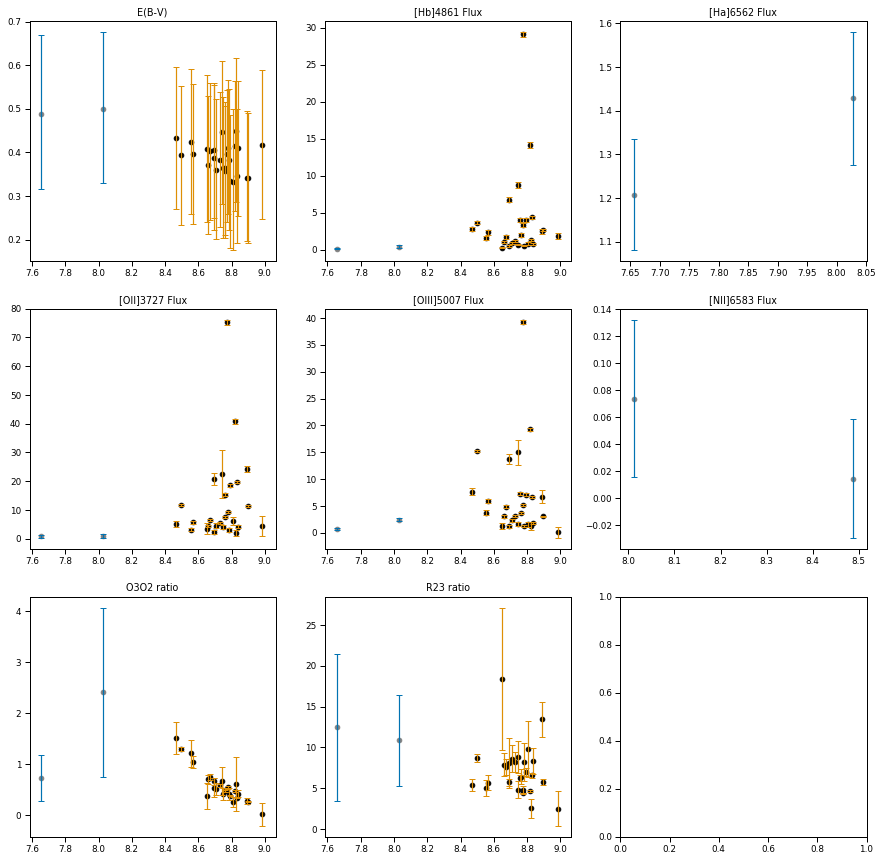

In [43]:
fig, axes = plt.subplots(3,3, figsize=(15,15))
ax = axes.flatten()

#E(B-V)
ax[0].errorbar(oiii_lines['metallicity_wRL'], oiii_lines['E(B-V)_wRL'], yerr=[E_bv_err_wRL_lo, E_bv_err_wRL_up], capsize=3, capthick=1, ls='none')
ax[0].scatter(oiii_lines['metallicity_wRL'], oiii_lines['E(B-V)_wRL'], color='grey')
ax[0].errorbar(oii_lines['metallicity'], oii_lines['E(B-V)'], yerr=[E_bv_err_lo, E_bv_err_up], capsize=3, capthick=1, ls='none')
ax[0].scatter(oii_lines['metallicity'], oii_lines['E(B-V)'], color='black')
ax[0].set_title('E(B-V)')

#Hb
ax[1].errorbar(oiii_lines['metallicity_wRL'], oiii_lines['[Hb]4861'], yerr = oiii_lines['[Hb]4861_e'], capsize=3, capthick=1, ls='none')
ax[1].scatter(oiii_lines['metallicity_wRL'], oiii_lines['[Hb]4861'], color='grey')
ax[1].errorbar(oii_lines['metallicity'], oii_lines['[Hb]4861'], yerr = oii_lines['[Hb]4861_e'], capsize=3, capthick=1, ls='none')
ax[1].scatter(oii_lines['metallicity'], oii_lines['[Hb]4861'], color='black')
ax[1].set_title('[Hb]4861 Flux')

#Ha
ax[2].errorbar(oiii_lines['metallicity_wRL'], oiii_lines['[Ha]6562'], yerr = oiii_lines['[Ha]6562_e'], capsize=3, capthick=1, ls='none')
ax[2].scatter(oiii_lines['metallicity_wRL'], oiii_lines['[Ha]6562'], color='grey')
ax[2].set_title('[Ha]6562 Flux')

#OII
ax[3].errorbar(oiii_lines['metallicity_wRL'], oiii_lines['[OII]3727'], yerr = oiii_lines['[OII]3727_e'], capsize=3, capthick=1, ls='none')
ax[3].scatter(oiii_lines['metallicity_wRL'], oiii_lines['[OII]3727'], color='grey')
ax[3].errorbar(oii_lines['metallicity'], oii_lines['[OII]3727'], yerr = oii_lines['[OII]3727_e'], capsize=3, capthick=1, ls='none')
ax[3].scatter(oii_lines['metallicity'], oii_lines['[OII]3727'], color='black')
ax[3].set_title('[OII]3727 Flux')

#OIII
ax[4].errorbar(oiii_lines['metallicity_wRL'], oiii_lines['[OIII]5007'], yerr = oiii_lines['[OIII]5007_e'], capsize=3, capthick=1, ls='none')
ax[4].scatter(oiii_lines['metallicity_wRL'], oiii_lines['[OIII]5007'], color='grey')
ax[4].errorbar(oii_lines['metallicity'], oii_lines['[OIII]5007'], yerr = oii_lines['[OIII]5007_e'], capsize=3, capthick=1, ls='none')
ax[4].scatter(oii_lines['metallicity'], oii_lines['[OIII]5007'], color='black')
ax[4].set_title('[OIII]5007 Flux')

#NII
ax[5].errorbar(oiii_lines['metallicity'], oiii_lines['[NII]6583'], yerr = oiii_lines['[NII]6583_e'], capsize=3, capthick=1, ls='none')
ax[5].scatter(oiii_lines['metallicity'], oiii_lines['[NII]6583'], color='grey')
ax[5].set_title('[NII]6583 Flux')

#O3O2
ax[6].errorbar(oiii_lines['metallicity_wRL'], oiii_O3O2, yerr = oiii_O3O2_e, capsize=3, capthick=1, ls='none')
ax[6].scatter(oiii_lines['metallicity_wRL'], oiii_O3O2, color='grey')
ax[6].errorbar(oii_lines['metallicity'], oii_O3O2, yerr = oii_O3O2_e, capsize=3, capthick=1, ls='none')
ax[6].scatter(oii_lines['metallicity'], oii_O3O2, color='black')
ax[6].set_title('O3O2 ratio')

#R23
ax[7].errorbar(oiii_lines['metallicity_wRL'], oiii_R23, yerr = oiii_R23_e, capsize=3, capthick=1, ls='none')
ax[7].scatter(oiii_lines['metallicity_wRL'], oiii_R23, color='grey')
ax[7].errorbar(oii_lines['metallicity'], oii_R23, yerr = oii_R23_e, capsize=3, capthick=1, ls='none')
ax[7].scatter(oii_lines['metallicity'], oii_R23, color='black')
ax[7].set_title('R23 ratio')

plt.show()

In [44]:
ec='black'

#plot the model curves with disperson 
r23_model_log   = np.log10(R23_model(met_norm))
o3o2_model_log  = np.log10(O3O2_model(met_norm))
ne3o2_model_log = np.log10(Ne3O2_model(met_norm))
n2_model_log    = np.log10(N2_model(met_norm))
o3n2_model_log  = np.log10(O3N2_model(met_norm))

p_e = 0.3

r23_model_log_e   = [np.log10(R23_model(met_norm)*(1-p_e)), np.log10(R23_model(met_norm)*(1+p_e))]
o3o2_model_log_e  = [np.log10(O3O2_model(met_norm)*(1-p_e)), np.log10(O3O2_model(met_norm)*(1+p_e))]
ne3o2_model_log_e = [np.log10(Ne3O2_model(met_norm)*(1-p_e)), np.log10(Ne3O2_model(met_norm)*(1+p_e))]
n2_model_log_e    = [np.log10(N2_model(met_norm)*(1-p_e)), np.log10(N2_model(met_norm)*(1+p_e))]
o3n2_model_log_e  = [np.log10(O3N2_model(met_norm)*(1-p_e)), np.log10(O3N2_model(met_norm)*(1+p_e))]

In [45]:
i=14

hps_name = flux_met_merge['HPS_name'].iloc[i]
hps_id = flux_met_merge['ID_x'].iloc[i]
met = flux_met_merge['metallicity'+met_end].iloc[i]
met_err_up = float(s.split(s.split(flux_met_merge['met_err'+met_end].iloc[i],'[')[1], ',')[0])
met_err_lo = float(s.split(s.split(flux_met_merge['met_err'+met_end].iloc[i],']')[0], ',')[1])

E_bv = flux_met_merge['E(B-V)'+met_end].iloc[i]
E_bv_err_up = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end].iloc[i],'[')[1], ',')[0])
E_bv_err_lo = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end].iloc[i],']')[0], ',')[1])


OII   = flux_met_merge['[OII]3727'].iloc[i]
OIII  = flux_met_merge['[OIII]5007'].iloc[i]
Hb    = flux_met_merge['[Hb]4861'].iloc[i]

Hb_ab   = flux_met_merge['Hb_absorption'].iloc[i]
Hb_corr = Hb+Hb_ab

OII_e   = flux_met_merge['[OII]3727_e'].iloc[i]
OIII_e  = flux_met_merge['[OIII]5007_e'].iloc[i]
Hb_e    = flux_met_merge['[Hb]4861_e'].iloc[i]

r23  = R23_ratio(OIII, OII, Hb_corr, E_bv)
o3o2 = O3O2_ratio(OIII, OII, E_bv)

r23_err_up  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv, E_bv_err_up)
r23_err_lo  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv, E_bv_err_lo)
o3o2_err_up = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv, E_bv_err_up)
o3o2_err_lo = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv, E_bv_err_lo)

r23_log_err_up  = (1/np.log(10))*(r23_err_up/r23)
r23_log_err_lo  = (1/np.log(10))*(r23_err_lo/r23)
o3o2_log_err_up = (1/np.log(10))*(o3o2_err_up/o3o2)
o3o2_log_err_lo = (1/np.log(10))*(o3o2_err_lo/o3o2)

print(hps_name, hps_id)
print('z:', met, 'E:', E_bv)
print('z:', met_err_up, 'E:', E_bv_err_up)
print('O2:', OII, 'O3:', OIII, 'Hb:', Hb,)
print('O2:', OII_e, 'O3:', OIII_e, 'Hb:', Hb_e,)
print('R23', r23, r23_err_up, r23_log_err_up)
print('O32', o3o2, o3o2_err_up, o3o2_log_err_up)

NameError: name 'met_end' is not defined

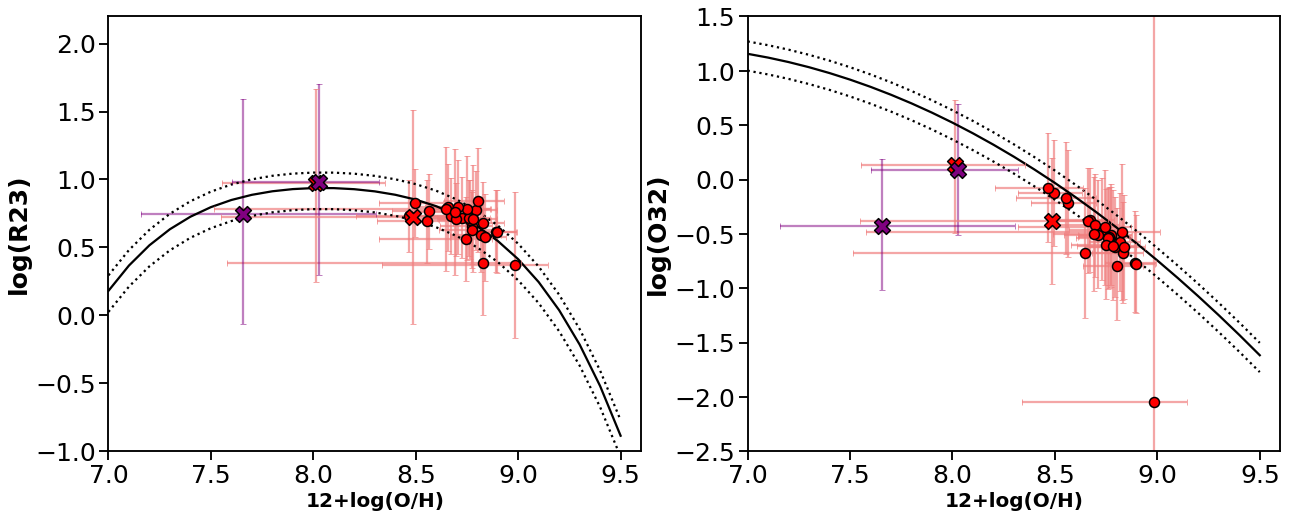

In [50]:
f, ax = plt.subplots(1, 2, sharex=True,figsize=(21, 8))
sns.set_context('talk')
#f.suptitle('Results')

ax[0].plot(met_range, r23_model_log, color='black')
ax[0].plot(met_range, r23_model_log_e[0], ls=':', color='black')
ax[0].plot(met_range, r23_model_log_e[1], ls=':', color='black')

ax[1].plot(met_range, o3o2_model_log, color='black')
ax[1].plot(met_range, o3o2_model_log_e[0], ls=':', color='black')
ax[1].plot(met_range, o3o2_model_log_e[1], ls=':', color='black')

#plot the axis labels
ax[0].set_ylabel('log(R23)', fontsize=25, fontweight='bold')
ax[1].set_ylabel('log(O32)', fontsize=25, fontweight='bold')
ax[0].set_ylim(-1.0,2.2)
ax[1].set_ylim(-2.5,1.5)

ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[1].tick_params(axis='both', which='major', labelsize=25)

for i in range(2):
    ax[i].set_xlabel('12+log(O/H)',fontsize=20, fontweight='bold')
    ax[i].set_xlim(7.0,9.6)

for i in range(len(flux_met_merge)):
    
    if flux_met_merge['selection'].iloc[i] == 'OII':
        met_end = ''
        mark = 'o'
        sz = 100
    elif flux_met_merge['selection'].iloc[i] == 'OIII':
        met_end = ''
        mark = 'X'
        sz = 250
        
        met_wRL = flux_met_merge['metallicity'+met_end+'_wRL'].iloc[i]
        met_err_up_wRL = float(s.split(s.split(flux_met_merge['met_err'+met_end+'_wRL'].iloc[i],'[')[1], ',')[0])
        met_err_lo_wRL = float(s.split(s.split(flux_met_merge['met_err'+met_end+'_wRL'].iloc[i],']')[0], ',')[1])
        
        E_bv_wRL = flux_met_merge['E(B-V)'+met_end+'_wRL'].iloc[i]
        E_bv_err_up_wRL = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end+'_wRL'].iloc[i],'[')[1], ',')[0])
        E_bv_err_lo_wRL = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end+'_wRL'].iloc[i],']')[0], ',')[1])

    hps_name = flux_met_merge['HPS_name'].iloc[i]
    hps_id = flux_met_merge['ID_x'].iloc[i]
    met = flux_met_merge['metallicity'+met_end].iloc[i]
    met_err_up = float(s.split(s.split(flux_met_merge['met_err'+met_end].iloc[i],'[')[1], ',')[0])
    met_err_lo = float(s.split(s.split(flux_met_merge['met_err'+met_end].iloc[i],']')[0], ',')[1])
    
    E_bv = flux_met_merge['E(B-V)'+met_end].iloc[i]
    E_bv_err_up = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end].iloc[i],'[')[1], ',')[0])
    E_bv_err_lo = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end].iloc[i],']')[0], ',')[1])

    
    OII   = flux_met_merge['[OII]3727'].iloc[i]
    OIII  = flux_met_merge['[OIII]5007'].iloc[i]
    Hb    = flux_met_merge['[Hb]4861'].iloc[i]

    Hb_ab   = flux_met_merge['Hb_absorption'].iloc[i]
    Hb_corr = Hb+Hb_ab

    OII_e   = flux_met_merge['[OII]3727_e'].iloc[i]
    OIII_e  = flux_met_merge['[OIII]5007_e'].iloc[i]
    Hb_e    = flux_met_merge['[Hb]4861_e'].iloc[i]

    Hb_ab_e   = Hb_ab*0.3 #30% error on measurement
    Hb_corr_e = np.sqrt((Hb_e**2) + (Hb_ab_e**2))
    
    r23  = R23_ratio(OIII, OII, Hb_corr, E_bv)
    o3o2 = O3O2_ratio(OIII, OII, E_bv)
    
    r23_err_up  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv, E_bv_err_up)
    r23_err_lo  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv, E_bv_err_lo)
    o3o2_err_up = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv, E_bv_err_up)
    o3o2_err_lo = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv, E_bv_err_lo)
    
    r23_log_err_up  = (1/np.log(10))*(r23_err_up/r23)
    r23_log_err_lo  = (1/np.log(10))*(r23_err_lo/r23)
    o3o2_log_err_up = (1/np.log(10))*(o3o2_err_up/o3o2)
    o3o2_log_err_lo = (1/np.log(10))*(o3o2_err_lo/o3o2)
        
    ax[0].errorbar([met], [np.log10(r23)], xerr=[[met_err_lo], [met_err_up]], yerr=[[r23_log_err_lo], [r23_log_err_up]], capsize=3, capthick=1, color='lightcoral', alpha=0.7)
    ax[0].scatter(met, np.log10(r23), color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
    
    #print hps_name, hps_id, met, np.log10(r23), r23_log_err_lo, r23_log_err_up, sz
    
    ax[1].errorbar([met], [np.log10(o3o2)], xerr=[[met_err_lo], [met_err_up]], yerr=[[o3o2_log_err_lo], [o3o2_log_err_up]], capsize=3, capthick=1, color='lightcoral', alpha=0.7)
    ax[1].scatter(met, np.log10(o3o2), color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
    
    if flux_met_merge['selection'].iloc[i] == 'OIII':
        #with red lines
        r23_wRL  = R23_ratio(OIII, OII, Hb_corr, E_bv_wRL)
        o3o2_wRL = O3O2_ratio(OIII, OII, E_bv_wRL)

        r23_err_up_wRL  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv_wRL, E_bv_err_up_wRL)
        r23_err_lo_wRL  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv_wRL, E_bv_err_lo_wRL)
        o3o2_err_up_wRL = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv_wRL, E_bv_err_up_wRL)
        o3o2_err_lo_wRL = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv_wRL, E_bv_err_lo_wRL)

        r23_log_err_up_wRL  = (1/np.log(10))*(r23_err_up_wRL/r23_wRL)
        r23_log_err_lo_wRL  = (1/np.log(10))*(r23_err_lo_wRL/r23_wRL)
        o3o2_log_err_up_wRL = (1/np.log(10))*(o3o2_err_up_wRL/o3o2_wRL)
        o3o2_log_err_lo_wRL = (1/np.log(10))*(o3o2_err_lo_wRL/o3o2_wRL)
        
        ax[0].errorbar([met_wRL], [np.log10(r23_wRL)], xerr=[[met_err_lo_wRL], [met_err_up_wRL]], yerr=[[r23_log_err_lo_wRL], [r23_log_err_up_wRL]], capsize=3, capthick=1, color='purple', alpha=0.5)
        ax[0].scatter(met_wRL, np.log10(r23_wRL), color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)

        ax[1].errorbar([met_wRL], [np.log10(o3o2_wRL)], xerr=[[met_err_lo_wRL], [met_err_up_wRL]], yerr=[[o3o2_log_err_lo_wRL], [o3o2_log_err_up_wRL]], capsize=3, capthick=1, color='purple', alpha=0.5)
        ax[1].scatter(met_wRL, np.log10(o3o2_wRL), color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)

        
    
plt.savefig(os.path.join(plot_path, 'maolino_vs_met.pdf'), bbox_inches='tight')
plt.show()        

/Users/Briana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in log10


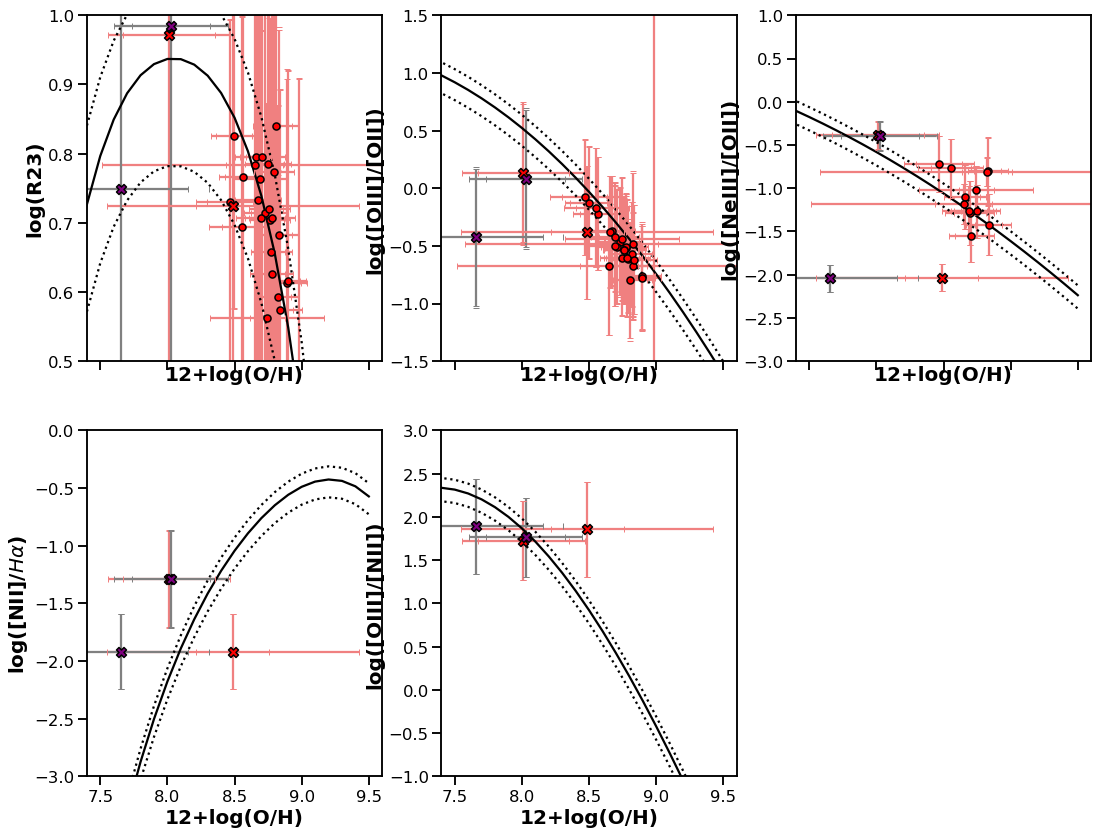

In [47]:
f, ax = plt.subplots(2, 3, sharex=True, figsize=(18, 14))
#f.suptitle('Results')

ec='black'

#plot the model curves with disperson 
r23_model_log   = np.log10(R23_model(met_norm))
o3o2_model_log  = np.log10(O3O2_model(met_norm))
ne3o2_model_log = np.log10(Ne3O2_model(met_norm))
n2_model_log    = np.log10(N2_model(met_norm))
o3n2_model_log  = np.log10(O3N2_model(met_norm))

p_e = 0.3

r23_model_log_e   = [np.log10(R23_model(met_norm)*(1-p_e)), np.log10(R23_model(met_norm)*(1+p_e))]
o3o2_model_log_e  = [np.log10(O3O2_model(met_norm)*(1-p_e)), np.log10(O3O2_model(met_norm)*(1+p_e))]
ne3o2_model_log_e = [np.log10(Ne3O2_model(met_norm)*(1-p_e)), np.log10(Ne3O2_model(met_norm)*(1+p_e))]
n2_model_log_e    = [np.log10(N2_model(met_norm)*(1-p_e)), np.log10(N2_model(met_norm)*(1+p_e))]
o3n2_model_log_e  = [np.log10(O3N2_model(met_norm)*(1-p_e)), np.log10(O3N2_model(met_norm)*(1+p_e))]

ax[0,0].plot(met_range, r23_model_log, color='black')
ax[0,0].plot(met_range, r23_model_log_e[0], ls=':', color='black')
ax[0,0].plot(met_range, r23_model_log_e[1], ls=':', color='black')

ax[0,1].plot(met_range, o3o2_model_log, color='black')
ax[0,1].plot(met_range, o3o2_model_log_e[0], ls=':', color='black')
ax[0,1].plot(met_range, o3o2_model_log_e[1], ls=':', color='black')

ax[0,2].plot(met_range, ne3o2_model_log, color='black')
ax[0,2].plot(met_range, ne3o2_model_log_e[0], ls=':', color='black')
ax[0,2].plot(met_range, ne3o2_model_log_e[1], ls=':', color='black')

ax[1,0].plot(met_range, n2_model_log, color='black')
ax[1,0].plot(met_range, n2_model_log_e[0], ls=':', color='black')
ax[1,0].plot(met_range, n2_model_log_e[1], ls=':', color='black')

ax[1,1].plot(met_range, o3n2_model_log, color='black')
ax[1,1].plot(met_range, o3n2_model_log_e[0], ls=':', color='black')
ax[1,1].plot(met_range, o3n2_model_log_e[1], ls=':', color='black')

#plot the axis labels
ax[0,0].set_ylabel('log(R23)', fontsize=20, fontweight='bold')
ax[0,1].set_ylabel('log([OIII]/[OII])', fontsize=20, fontweight='bold')
ax[0,2].set_ylabel('log([NeIII]/[OII])', fontsize=20, fontweight='bold')
ax[1,0].set_ylabel(r'log([NII]/$H\alpha$)', fontsize=20, fontweight='bold')
ax[1,1].set_ylabel('log([OIII]/[NII])', fontsize=20, fontweight='bold')

#ax[0,0].set_ylim(-1.0,2.2)
ax[0,0].set_ylim(0.5,1.0)
ax[0,1].set_ylim(-1.5,1.5)
ax[0,2].set_ylim(-3.0,1.0)
ax[1,0].set_ylim(-3.0,0.0)
ax[1,1].set_ylim(-1.0,3.0)

for i in range(3):
    ax[0,i].set_xlabel('12+log(O/H)',fontsize=20, fontweight='bold')
    ax[0,i].set_xlim(7.4,9.6)
    
for i in range(2):
    ax[1,i].set_xlabel('12+log(O/H)',fontsize=20, fontweight='bold')
    ax[1,i].set_xlim(7.4,9.6)

for i in range(len(flux_met_merge)):
    
    if flux_met_merge['selection'].iloc[i] == 'OII':
        met_end = ''
        mark = 'o'
        sz = 50
    elif flux_met_merge['selection'].iloc[i] == 'OIII':
        met_end = ''
        mark = 'X'
        sz = 100
        
        met_wRL = flux_met_merge['metallicity'+met_end+'_wRL'].iloc[i]
        met_err_up_wRL = float(s.split(s.split(flux_met_merge['met_err'+met_end+'_wRL'].iloc[i],'[')[1], ',')[0])
        met_err_lo_wRL = float(s.split(s.split(flux_met_merge['met_err'+met_end+'_wRL'].iloc[i],']')[0], ',')[1])
        
        E_bv_wRL = flux_met_merge['E(B-V)'+met_end+'_wRL'].iloc[i]
        E_bv_err_up_wRL = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end+'_wRL'].iloc[i],'[')[1], ',')[0])
        E_bv_err_lo_wRL = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end+'_wRL'].iloc[i],']')[0], ',')[1])

    met = flux_met_merge['metallicity'+met_end].iloc[i]
    met_err_up = float(s.split(s.split(flux_met_merge['met_err'+met_end].iloc[i],'[')[1], ',')[0])
    met_err_lo = float(s.split(s.split(flux_met_merge['met_err'+met_end].iloc[i],']')[0], ',')[1])
    
    E_bv = flux_met_merge['E(B-V)'+met_end].iloc[i]
    E_bv_err_up = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end].iloc[i],'[')[1], ',')[0])
    E_bv_err_lo = float(s.split(s.split(flux_met_merge['E(B-V)_err'+met_end].iloc[i],']')[0], ',')[1])
    
    OII   = flux_met_merge['[OII]3727'].iloc[i]
    OIII  = flux_met_merge['[OIII]5007'].iloc[i]
    Hb    = flux_met_merge['[Hb]4861'].iloc[i]
    NeIII = flux_met_merge['[NeIII]3870'].iloc[i]
    NII   = flux_met_merge['[NII]6583'].iloc[i]
    Ha    = flux_met_merge['[Ha]6562'].iloc[i]

    Hb_ab   = flux_met_merge['Hb_absorption'].iloc[i]
    Hb_corr = Hb+Hb_ab

    OII_e   = flux_met_merge['[OII]3727_e'].iloc[i]
    OIII_e  = flux_met_merge['[OIII]5007_e'].iloc[i]
    Hb_e    = flux_met_merge['[Hb]4861_e'].iloc[i]
    NeIII_e = flux_met_merge['[NeIII]3870_e'].iloc[i]
    NII_e   = flux_met_merge['[NII]6583_e'].iloc[i]
    Ha_e    = flux_met_merge['[Ha]6562_e'].iloc[i]

    Hb_ab_e   = Hb_ab*0.3 #30% error on measurement
    Hb_corr_e = np.sqrt((Hb_e**2) + (Hb_ab_e**2))
    
    r23  = R23_ratio(OIII, OII, Hb_corr, E_bv)
    o3o2 = O3O2_ratio(OIII, OII, E_bv)
    
    r23_err_up  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv, E_bv_err_up)
    r23_err_lo  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv, E_bv_err_lo)
    o3o2_err_up = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv, E_bv_err_up)
    o3o2_err_lo = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv, E_bv_err_lo)
    
    r23_log_err_up  = (1/np.log(10))*(r23_err_up/r23)
    r23_log_err_lo  = (1/np.log(10))*(r23_err_lo/r23)
    o3o2_log_err_up = (1/np.log(10))*(o3o2_err_up/o3o2)
    o3o2_log_err_lo = (1/np.log(10))*(o3o2_err_lo/o3o2)
        
    ax[0,0].errorbar([met], [np.log10(r23)], xerr=[[met_err_lo, met_err_up]], yerr=[[r23_log_err_lo, r23_log_err_up]], capsize=3, capthick=1, color='lightcoral')
    ax[0,0].scatter(met, np.log10(r23), color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
    
    ax[0,1].errorbar([met], [np.log10(o3o2)], xerr=[[met_err_lo, met_err_up]], yerr=[[o3o2_log_err_lo, o3o2_log_err_up]], capsize=3, capthick=1, color='lightcoral')
    ax[0,1].scatter(met, np.log10(o3o2), color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
    
    if flux_met_merge['selection'].iloc[i] == 'OIII':
        #with red lines
        r23_wRL  = R23_ratio(OIII, OII, Hb_corr, E_bv_wRL)
        o3o2_wRL = O3O2_ratio(OIII, OII, E_bv_wRL)

        r23_err_up_wRL  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv_wRL, E_bv_err_up_wRL)
        r23_err_lo_wRL  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv_wRL, E_bv_err_lo_wRL)
        o3o2_err_up_wRL = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv_wRL, E_bv_err_up_wRL)
        o3o2_err_lo_wRL = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv_wRL, E_bv_err_lo_wRL)

        r23_log_err_up_wRL  = (1/np.log(10))*(r23_err_up_wRL/r23_wRL)
        r23_log_err_lo_wRL  = (1/np.log(10))*(r23_err_lo_wRL/r23_wRL)
        o3o2_log_err_up_wRL = (1/np.log(10))*(o3o2_err_up_wRL/o3o2_wRL)
        o3o2_log_err_lo_wRL = (1/np.log(10))*(o3o2_err_lo_wRL/o3o2_wRL)
        
        ax[0,0].errorbar([met_wRL], [np.log10(r23_wRL)], xerr=[[met_err_lo_wRL, met_err_up_wRL]], yerr=[[r23_log_err_lo_wRL, r23_log_err_up_wRL]], capsize=3, capthick=1, color='grey')
        ax[0,0].scatter(met_wRL, np.log10(r23_wRL), color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)

        ax[0,1].errorbar([met_wRL], [np.log10(o3o2_wRL)], xerr=[[met_err_lo_wRL, met_err_up_wRL]], yerr=[[o3o2_log_err_lo_wRL, o3o2_log_err_up_wRL]], capsize=3, capthick=1, color='grey')
        ax[0,1].scatter(met_wRL, np.log10(o3o2_wRL), color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)

    
    #if (~np.isnan(NeIII)) and (flux_met_merge['Source'].iloc[i] == 'HPS' ):
    if (~np.isnan(NeIII)):
        ne3o2 = np.log10(Ne3O2_ratio(NeIII, OII, E_bv))
        ne3o2_err_up = np.log10(Ne3O2_ratio_err(NeIII, OII, NeIII_e, OII_e, E_bv, E_bv_err_up))
        ne3o2_err_lo = np.log10(Ne3O2_ratio_err(NeIII, OII, NeIII_e, OII_e, E_bv, E_bv_err_lo))
        ne3o2_log_err_up = (1/np.log(10))*(ne3o2_err_up/ne3o2)
        ne3o2_log_err_lo = (1/np.log(10))*(ne3o2_err_lo/ne3o2)
        
        ax[0,2].errorbar([met], [ne3o2], xerr=[[met_err_lo, met_err_up]], yerr=[[ne3o2_log_err_lo, ne3o2_log_err_up]], capsize=3, capthick=1, color='lightcoral')
        ax[0,2].scatter(met, ne3o2, color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
        
        if flux_met_merge['selection'].iloc[i] == 'OIII':
            ne3o2_wRL = np.log10(Ne3O2_ratio(NeIII, OII, E_bv_wRL))
            ne3o2_err_up_wRL = np.log10(Ne3O2_ratio_err(NeIII, OII, NeIII_e, OII_e, E_bv_wRL, E_bv_err_up_wRL))
            ne3o2_err_lo_wRL = np.log10(Ne3O2_ratio_err(NeIII, OII, NeIII_e, OII_e, E_bv_wRL, E_bv_err_lo_wRL))
            ne3o2_log_err_up_wRL = (1/np.log(10))*(ne3o2_err_up_wRL/ne3o2_wRL)
            ne3o2_log_err_lo_wRL = (1/np.log(10))*(ne3o2_err_lo_wRL/ne3o2_wRL)

            ax[0,2].errorbar([met_wRL], [ne3o2_wRL], xerr=[[met_err_lo_wRL, met_err_up_wRL]], yerr=[[ne3o2_log_err_lo_wRL, ne3o2_log_err_up_wRL]], capsize=3, capthick=1, color='grey')
            ax[0,2].scatter(met_wRL, ne3o2_wRL, color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)

        
    if (~np.isnan(NII)):
        n2 = np.log10(N2_ratio(NII, Ha, E_bv))
        n2_err_up = np.log10(N2_ratio_err(NII, Ha, NII_e, Ha_e, E_bv, E_bv_err_up))
        n2_err_lo = np.log10(N2_ratio_err(NII, Ha, NII_e, Ha_e, E_bv, E_bv_err_lo))
        n2_log_err_up = (1/np.log(10))*(n2_err_up/n2)
        n2_log_err_lo = (1/np.log(10))*(n2_err_lo/n2)
        
        ax[1,0].errorbar([met], [n2], xerr=[[met_err_lo, met_err_up]], yerr=[[n2_log_err_lo, n2_log_err_up]], capsize=3, capthick=1, color='lightcoral')
        ax[1,0].scatter(met, n2, color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
        
        o3n2 = np.log10(O3N2_ratio(OIII, NII, E_bv))
        o3n2_err_up = np.log10(O3N2_ratio_err(OIII, NII, OIII_e, NII_e, E_bv, E_bv_err_up))
        o3n2_err_lo = np.log10(O3N2_ratio_err(OIII, NII, OIII_e, NII_e, E_bv, E_bv_err_lo))
        o3n2_log_err_up = (1/np.log(10))*(o3n2_err_up/o3n2)
        o3n2_log_err_lo = (1/np.log(10))*(o3n2_err_lo/o3n2)
        
        ax[1,1].errorbar([met], [o3n2], xerr=[[met_err_lo, met_err_up]], yerr=[[o3n2_log_err_lo, o3n2_log_err_up]], capsize=3, capthick=1, color='lightcoral')
        ax[1,1].scatter(met, o3n2, color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
        
        if flux_met_merge['selection'].iloc[i] == 'OIII':
            n2_wRL = np.log10(N2_ratio(NII, Ha, E_bv_wRL))
            n2_err_up_wRL = np.log10(N2_ratio_err(NII, Ha, NII_e, Ha_e, E_bv_wRL, E_bv_err_up_wRL))
            n2_err_lo_wRL = np.log10(N2_ratio_err(NII, Ha, NII_e, Ha_e, E_bv_wRL, E_bv_err_lo_wRL))
            n2_log_err_up_wRL = (1/np.log(10))*(n2_err_up_wRL/n2_wRL)
            n2_log_err_lo_wRL = (1/np.log(10))*(n2_err_lo_wRL/n2_wRL)

            ax[1,0].errorbar([met_wRL], [n2_wRL], xerr=[[met_err_lo_wRL, met_err_up_wRL]], yerr=[[n2_log_err_lo_wRL, n2_log_err_up_wRL]], capsize=3, capthick=1, color='grey')
            ax[1,0].scatter(met_wRL, n2_wRL, color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)

            o3n2_wRL = np.log10(O3N2_ratio(OIII, NII, E_bv_wRL))
            o3n2_err_up_wRL = np.log10(O3N2_ratio_err(OIII, NII, OIII_e, NII_e, E_bv_wRL, E_bv_err_up_wRL))
            o3n2_err_lo_wRL = np.log10(O3N2_ratio_err(OIII, NII, OIII_e, NII_e, E_bv_wRL, E_bv_err_lo_wRL))
            o3n2_log_err_up_wRL = (1/np.log(10))*(o3n2_err_up_wRL/o3n2_wRL)
            o3n2_log_err_lo_wRL = (1/np.log(10))*(o3n2_err_lo_wRL/o3n2_wRL)

            ax[1,1].errorbar([met_wRL], [o3n2_wRL], xerr=[[met_err_lo_wRL, met_err_up_wRL]], yerr=[[o3n2_log_err_lo_wRL, o3n2_log_err_up_wRL]], capsize=3, capthick=1, color='grey')
            ax[1,1].scatter(met_wRL, o3n2_wRL, color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)


ax[1,2].axis('off')
plt.savefig(os.path.join(plot_path, 'maolino_vs_met_all.png'))
plt.show()        

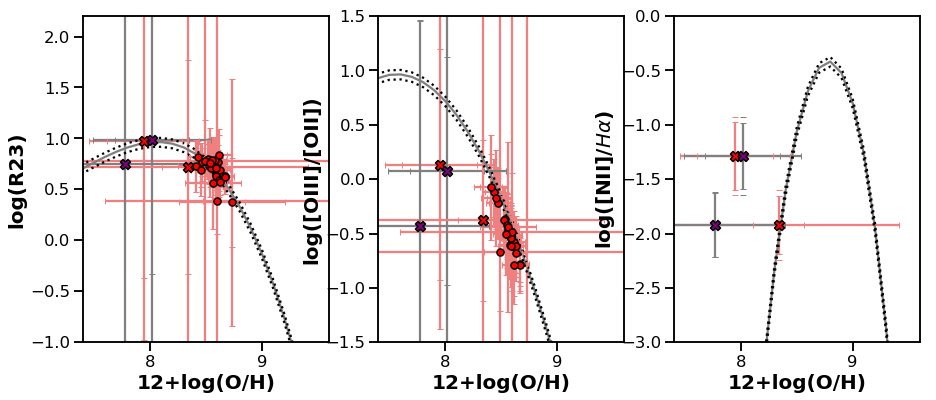

In [36]:
ratio_dict = {'R23':R23_model_c, 'O3O2':O3O2_model_c, 'N2':N2_model_c}

f, ax = plt.subplots(1, 3, sharex=True, figsize=(15,6))
#f.suptitle('Results')

ec='black'

#plot the model curves with disperson 
r23_model_log_c  = np.log10(R23_model_c(met_norm))
o3o2_model_log_c = np.log10(O3O2_model_c(met_norm))
n2_model_log_c   = np.log10(N2_model_c(met_norm))

p_e = 0.1

r23_model_log_c_e   = [np.log10(R23_model_c(met_norm)*(1-p_e)), np.log10(R23_model_c(met_norm)*(1+p_e))]
o3o2_model_log_c_e  = [np.log10(O3O2_model_c(met_norm)*(1-p_e)), np.log10(O3O2_model_c(met_norm)*(1+p_e))]
n2_model_log_c_e    = [np.log10(N2_model_c(met_norm)*(1-p_e)), np.log10(N2_model_c(met_norm)*(1+p_e))]

ax[0].plot(met_range, r23_model_log_c, color='grey') #curti
ax[0].plot(met_range, r23_model_log_c_e[0], ls=':', color='black')
ax[0].plot(met_range, r23_model_log_c_e[1], ls=':', color='black')

ax[1].plot(met_range, o3o2_model_log_c, color='grey') #curti 
ax[1].plot(met_range, o3o2_model_log_c_e[0], ls=':', color='black')
ax[1].plot(met_range, o3o2_model_log_c_e[1], ls=':', color='black')

ax[2].plot(met_range, n2_model_log_c, color='grey')
ax[2].plot(met_range, n2_model_log_c_e[0], ls=':', color='black')
ax[2].plot(met_range, n2_model_log_c_e[1], ls=':', color='black')

#plot the axis labels
ax[0].set_ylabel('log(R23)', fontsize=20, fontweight='bold')
ax[1].set_ylabel('log([OIII]/[OII])', fontsize=20, fontweight='bold')
ax[2].set_ylabel(r'log([NII]/$H\alpha$)', fontsize=20, fontweight='bold')

ax[0].set_ylim(-1.0,2.2)
ax[1].set_ylim(-1.5,1.5)
ax[2].set_ylim(-3.0,0.0)

for i in range(3):
    ax[i].set_xlabel('12+log(O/H)',fontsize=20, fontweight='bold')
    ax[i].set_xlim(7.4,9.6)

for i in range(len(flux_met_merge)):
    
    if flux_met_merge['selection'].iloc[i] == 'OII':
        met_end = 'c'
        mark = 'o'
        sz = 50
    elif flux_met_merge['selection'].iloc[i] == 'OIII':
        met_end = 'c'
        mark = 'X'
        sz = 100
        
        met_wRL = flux_met_merge['metallicity_wRL_'+met_end].iloc[i]
        met_err_up_wRL = float(s.split(s.split(flux_met_merge['met_err_wRL_'+met_end].iloc[i],'[')[1], ',')[0])
        met_err_lo_wRL = float(s.split(s.split(flux_met_merge['met_err_wRL_'+met_end].iloc[i],']')[0], ',')[1])

        E_bv_wRL = flux_met_merge['E(B-V)_wRL_'+met_end].iloc[i]
        E_bv_err_up_wRL = float(s.split(s.split(flux_met_merge['E(B-V)_err_wRL_'+met_end].iloc[i],'[')[1], ',')[0])
        E_bv_err_lo_wRL = float(s.split(s.split(flux_met_merge['E(B-V)_err_wRL_'+met_end].iloc[i],']')[0], ',')[1])

        
    met = flux_met_merge['metallicity_'+met_end].iloc[i]
    met_err_up = float(s.split(s.split(flux_met_merge['met_err_'+met_end].iloc[i],'[')[1], ',')[0])
    met_err_lo = float(s.split(s.split(flux_met_merge['met_err_'+met_end].iloc[i],']')[0], ',')[1])
    
    E_bv = flux_met_merge['E(B-V)_'+met_end].iloc[i]
    E_bv_err_up = float(s.split(s.split(flux_met_merge['E(B-V)_err_'+met_end].iloc[i],'[')[1], ',')[0])
    E_bv_err_lo = float(s.split(s.split(flux_met_merge['E(B-V)_err_'+met_end].iloc[i],']')[0], ',')[1])
    
    OII   = flux_met_merge['[OII]3727'].iloc[i]
    OIII  = flux_met_merge['[OIII]5007'].iloc[i]
    Hb    = flux_met_merge['[Hb]4861'].iloc[i]
    NeIII = flux_met_merge['[NeIII]3870'].iloc[i]
    NII   = flux_met_merge['[NII]6583'].iloc[i]
    Ha    = flux_met_merge['[Ha]6562'].iloc[i]

    Hb_ab   = flux_met_merge['Hb_absorption'].iloc[i]
    Hb_corr = Hb+Hb_ab

    OII_e   = flux_met_merge['[OII]3727_e'].iloc[i]
    OIII_e  = flux_met_merge['[OIII]5007_e'].iloc[i]
    Hb_e    = flux_met_merge['[Hb]4861_e'].iloc[i]
    NeIII_e = flux_met_merge['[NeIII]3870_e'].iloc[i]
    NII_e   = flux_met_merge['[NII]6583_e'].iloc[i]
    Ha_e    = flux_met_merge['[Ha]6562_e'].iloc[i]

    Hb_ab_e   = Hb_ab*0.3 #30% error on measurement
    Hb_corr_e = np.sqrt((Hb_e**2) + (Hb_ab_e**2))
    
    r23  = R23_ratio(OIII, OII, Hb_corr, E_bv)
    o3o2 = O3O2_ratio(OIII, OII, E_bv)
    
    r23_err_up  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv, E_bv_err_up)
    r23_err_lo  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv, E_bv_err_lo)
    o3o2_err_up = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv, E_bv_err_up)
    o3o2_err_lo = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv, E_bv_err_lo)
    
    r23_log_err_up  = (1/np.log(10))*(r23_err_up/r23)
    r23_log_err_lo  = (1/np.log(10))*(r23_err_lo/r23)
    o3o2_log_err_up = (1/np.log(10))*(o3o2_err_up/o3o2)
    o3o2_log_err_lo = (1/np.log(10))*(o3o2_err_lo/o3o2)
        
    ax[0].errorbar([met], [np.log10(r23)], xerr=[[met_err_lo, met_err_up]], yerr=[[r23_log_err_lo, r23_log_err_up]], capsize=3, capthick=1, color='lightcoral')
    ax[0].scatter(met, np.log10(r23), color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
    
    ax[1].errorbar([met], [np.log10(o3o2)], xerr=[[met_err_lo, met_err_up]], yerr=[[o3o2_log_err_lo, o3o2_log_err_up]], capsize=3, capthick=1, color='lightcoral')
    ax[1].scatter(met, np.log10(o3o2), color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
   
    if flux_met_merge['selection'].iloc[i] == 'OIII':
        r23_wRL  = R23_ratio(OIII, OII, Hb_corr, E_bv_wRL)
        o3o2_wRL = O3O2_ratio(OIII, OII, E_bv_wRL)

        r23_err_up_wRL  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv_wRL, E_bv_err_up_wRL)
        r23_err_lo_wRL  = R23_ratio_err(OIII, OII, Hb_corr, OIII_e, OII_e, Hb_corr_e, E_bv_wRL, E_bv_err_lo_wRL)
        o3o2_err_up_wRL = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv_wRL, E_bv_err_up_wRL)
        o3o2_err_lo_wRL = O3O2_ratio_err(OIII, OII, OIII_e, OII_e, E_bv_wRL, E_bv_err_lo_wRL)

        r23_log_err_up_wRL  = (1/np.log(10))*(r23_err_up_wRL/r23_wRL)
        r23_log_err_lo_wRL  = (1/np.log(10))*(r23_err_lo_wRL/r23_wRL)
        o3o2_log_err_up_wRL = (1/np.log(10))*(o3o2_err_up_wRL/o3o2_wRL)
        o3o2_log_err_lo_wRL = (1/np.log(10))*(o3o2_err_lo_wRL/o3o2_wRL)

        ax[0].errorbar([met_wRL], [np.log10(r23_wRL)], xerr=[[met_err_lo_wRL, met_err_up_wRL]], yerr=[[r23_log_err_lo_wRL, r23_log_err_up_wRL]], capsize=3, capthick=1, color='grey')
        ax[0].scatter(met_wRL, np.log10(r23_wRL), color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)

        ax[1].errorbar([met_wRL], [np.log10(o3o2_wRL)], xerr=[[met_err_lo_wRL, met_err_up_wRL]], yerr=[[o3o2_log_err_lo_wRL, o3o2_log_err_up_wRL]], capsize=3, capthick=1, color='grey')
        ax[1].scatter(met_wRL, np.log10(o3o2_wRL), color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)


    if (~np.isnan(NII)):
        n2 = np.log10(N2_ratio(NII, Ha, E_bv))
        n2_err_up = np.log10(N2_ratio_err(NII, Ha, NII_e, Ha_e, E_bv, E_bv_err_up))
        n2_err_lo = np.log10(N2_ratio_err(NII, Ha, NII_e, Ha_e, E_bv, E_bv_err_lo))
        n2_log_err_up = (1/np.log(10))*(n2_err_up/n2)
        n2_log_err_lo = (1/np.log(10))*(n2_err_lo/n2)
        
        ax[2].errorbar([met], [n2], xerr=[[met_err_lo, met_err_up]], yerr=[[n2_log_err_lo, n2_log_err_up]], capsize=3, capthick=1, color='lightcoral')
        ax[2].scatter(met, n2, color='red', marker=mark, s=sz, edgecolors=ec, zorder=1000)
        
        if flux_met_merge['selection'].iloc[i] == 'OIII':
            n2_wRL = np.log10(N2_ratio(NII, Ha, E_bv_wRL))
            n2_err_up_wRL = np.log10(N2_ratio_err(NII, Ha, NII_e, Ha_e, E_bv_wRL, E_bv_err_up_wRL))
            n2_err_lo_wRL = np.log10(N2_ratio_err(NII, Ha, NII_e, Ha_e, E_bv_wRL, E_bv_err_lo_wRL))
            n2_log_err_up_wRL = (1/np.log(10))*(n2_err_up_wRL/n2_wRL)
            n2_log_err_lo_wRL = (1/np.log(10))*(n2_err_lo_wRL/n2_wRL)

            ax[2].errorbar([met_wRL], [n2_wRL], xerr=[[met_err_lo_wRL, met_err_up_wRL]], yerr=[[n2_log_err_lo_wRL, n2_log_err_up_wRL]], capsize=3, capthick=1, color='grey')
            ax[2].scatter(met_wRL, n2_wRL, color='purple', marker=mark, s=sz, edgecolors=ec, zorder=1000)

        
plt.savefig(os.path.join(plot_path, 'curti_vs_met.png'))
plt.show()        